### Analysis of the optics measurement made on the MWPC and the BPMs
### 3nd measurement
## MWPC focal without BTV screen in

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from pybt.tools.plotters import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def current(k, magnet_type, Brho):
    
    A_Q74L = [0.0,
    5.000978,
    10.000304,
    50.002003,
    100.001404,
    150.001373,
    200.00238,
    250.005432,
    299.993652,
    350.001648,
    399.995728,
    449.994446,
    499.997375,
    549.999878,
    599.994873,
    650.004211,
    666.999146,
    699.991455,
    749.998169,
    799.996643]
    
    T_Q74L = [0.0,
    0.2619,
    0.492968,
    2.358847,
    4.710821,
    7.068205,
    9.426532,
    11.780794,
    14.131984,
    16.4773,
    18.814776,
    21.133094,
    23.416058,
    25.617934,
    27.638804,
    29.43015,
    29.981004,
    30.987122,
    32.347211,
    33.545971]
    
    L_Q74L = 0.74
    
    A_Q120C = [0.00,
    50.00,
    100.00,
    150.00,
    200.00,
    250.00,
    300.00,
    350.00,
    400.00,
    450.00,
    500.00,
    550.00,
    600.00,
    650.00]
    
    T_Q120C = [0.00,
    2.05,
    4.12,
    6.19,
    8.26,
    10.33,
    12.39,
    14.43,
    16.44,
    18.36,
    20.14,
    21.74,
    23.01,
    24.07]
    
    L_Q120C = 1.2
    
    A_QFL = [0,
    94.15,
    145.76,
    197.97,
    250.74,
    300.18,
    350.7,
    402,
    451.15,
    502.09,
    551.47]
    
    T_QFL = [0,
    4.86,
    7.48,
    10.158,
    12.875,
    15.377,
    17.81,
    20.045,
    21.844,
    23.217,
    24.445]
    
    L_QFL = 1.2
    
    A_QFS = [0,
    98.95,
    147.71,
    197.23,
    249.64,
    301.81,
    351.91,
    400.77,
    454.51,
    506.28,
    555.25]
    
    T_QFS = [0,
    3.462,
    5.158,
    6.875,
    8.686,
    10.48,
    12.14,
    13.57,
    14.79,
    15.75,
    16.49]
    
    L_QFS = 0.8
    
    A_Q200L = [0.0,
    5.0,
    10.0,
    50.0,
    100.0,
    150.0,
    200.0,
    250.0,
    300.0,
    350.0,
    400.0,
    450.0,
    500.0,
    540.0,
    600.0,
    650.0,
    700.0,
    750.0,
    800.0,
    850.0]
    
    T_Q200L = [0.0,
    0.20,
    0.38,
    1.85,
    3.69,
    5.54,
    7.39,
    9.23,
    11.08,
    12.91,
    14.74,
    16.54,
    18.28,
    19.58,
    21.34,
    22.57,
    23.57,
    24.38,
    25.08,
    25.67]
    
    L_Q200L = 2.0
    
    if magnet_type == "Q74L":
        measured_currents = A_Q74L
        measured_int_gradient = T_Q74L
        length = L_Q74L
        
    if magnet_type == "Q120C":
        measured_currents = A_Q120C
        measured_int_gradient = T_Q120C
        length = L_Q120C
        
    if magnet_type == "QFL":
        measured_currents = A_QFL
        measured_int_gradient = T_QFL
        length = L_QFL
        
    if magnet_type == "QFS":
        measured_currents = A_QFS
        measured_int_gradient = T_QFS
        length = L_QFS
        
    if magnet_type == "Q200L":
        measured_currents = A_Q200L
        measured_int_gradient = T_Q200L
        length = L_Q200L
    
    int_grad = k*length * Brho
    current = np.interp(int_grad, measured_int_gradient, measured_currents)    
    
    return current

In [3]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov
def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

In [4]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/quad-scan-east/"
end_path = "quad_scan_t8_bpms_data"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [5]:
dirnames

['quad_scan_t8_bpms_2022_07_27_14h40m42s',
 'quad_scan_t8_bpms_2022_07_27_16h19m08s',
 'quad_scan_t8_bpms_2022_07_27_17h01m48s',
 'quad_scan_t8_bpms_2022_07_27_17h40m18s']

### Opening the first measurement which is a MWPC scan

In [6]:
subset_dirnames = [dirnames[2]]
subset_dirnames

['quad_scan_t8_bpms_2022_07_27_17h01m48s']

In [7]:
for dirname in subset_dirnames:
    print (dirname)
    infile = open(start_path+end_path+"/"+dirname+"/"+dirname+".p", 'rb')
    loaded_pickle = pickle.load(infile)

quad_scan_t8_bpms_2022_07_27_17h01m48s


#### Time

In [8]:
loaded_pickle[0][0]

datetime.datetime(2022, 7, 27, 17, 1, 52, 872202)

#### Measured pulse

In [9]:
loaded_pickle[1].keys()

dict_keys(['F61.QFN01/MEAS.PULSE#VALUE', 'F61.QDN02/MEAS.PULSE#VALUE', 'F61.QFN03/MEAS.PULSE#VALUE', 'F61.QDN04/MEAS.PULSE#VALUE', 'T8.QFN05/MEAS.PULSE#VALUE', 'T8.QDN06/MEAS.PULSE#VALUE', 'T8.QDN07/MEAS.PULSE#VALUE', 'T8.QFN08/MEAS.PULSE#VALUE'])

In [10]:
loaded_pickle[1]

{'F61.QFN01/MEAS.PULSE#VALUE': [624.080078125,
  624.0834350585938,
  624.0809326171875,
  624.0845336914062,
  624.0882568359375,
  624.0762329101562,
  624.0780029296875,
  624.0792236328125,
  624.084228515625,
  624.0838623046875,
  624.0789794921875,
  624.0858764648438,
  624.0750732421875,
  624.0817260742188,
  624.087890625,
  624.074462890625,
  624.0816650390625,
  624.0843505859375,
  624.0860595703125,
  624.0828857421875,
  624.080078125,
  624.083740234375,
  624.0833740234375,
  624.0834350585938,
  624.0780029296875,
  624.0789184570312,
  624.0806884765625,
  624.0760498046875,
  624.0763549804688,
  624.0791015625,
  624.0811157226562,
  624.0806274414062,
  624.083740234375,
  624.07958984375,
  624.0796508789062,
  624.0758056640625,
  624.0792236328125,
  624.078369140625,
  624.07421875,
  624.08154296875,
  624.07763671875,
  624.0811767578125,
  624.0806884765625,
  624.0751953125,
  624.0807495117188,
  624.0803833007812,
  624.0804443359375,
  624.08557128906

#### K Func list F61

In [11]:
loaded_pickle[2].keys()

dict_keys(['logical.F61.QFN01/K_FUNC_LIST#value', 'logical.F61.QDN02/K_FUNC_LIST#value', 'logical.F61.QFN03/K_FUNC_LIST#value', 'logical.F61.QDN04/K_FUNC_LIST#value'])

In [12]:
loaded_pickle[2]['logical.F61.QFN01/K_FUNC_LIST#value'][0][0][1][0]

0.47969

#### Intensity in the PS

In [13]:
loaded_pickle[3][0]

19.808887481689453

#### I Func list

In [14]:
loaded_pickle[4].keys()

dict_keys(['logical.F61.QFN01/I_FUNC_LIST#value', 'logical.F61.QDN02/I_FUNC_LIST#value', 'logical.F61.QFN03/I_FUNC_LIST#value', 'logical.F61.QDN04/I_FUNC_LIST#value'])

#### OASIS current

In [15]:
loaded_pickle[5].keys()

dict_keys(['F61.QFN01/LOG.OASIS.I_MEAS#DATA', 'F61.QDN02/LOG.OASIS.I_MEAS#DATA', 'F61.QFN03/LOG.OASIS.I_MEAS#DATA', 'F61.QDN04/LOG.OASIS.I_MEAS#DATA', 'F61.QFN05/LOG.OASIS.I_MEAS#DATA', 'F61.QDN06/LOG.OASIS.I_MEAS#DATA', 'F61.QDN07/LOG.OASIS.I_MEAS#DATA', 'F61.QFN08/LOG.OASIS.I_MEAS#DATA'])

#### K Func list T8

In [16]:
loaded_pickle[6].keys()

dict_keys(['logical.T8.QFN05/K_FUNC_LIST#value', 'logical.T8.QDN06/K_FUNC_LIST#value', 'logical.T8.QDN07/K_FUNC_LIST#value', 'logical.T8.QFN08/K_FUNC_LIST#value'])

#### IRRAD BPM UCAP Positions

In [17]:
loaded_pickle[7].keys()

dict_keys(['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions', 'PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions', 'PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions', 'PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions'])

In [18]:
loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions'][0]["HSigma"]

3.960909033063412

#### IRRAD BPM UCAP Profiles

In [19]:
loaded_pickle[8].keys()

dict_keys(['PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition', 'PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition', 'PS-LOG-BPM-IRRAD-UCAP_BPM_03/ProfilesAcquisition', 'PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition'])

In [20]:
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][0]["HRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][0]["HRawProfile"][1]

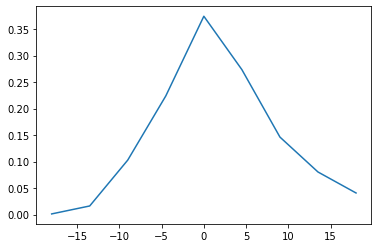

In [21]:
fig, ax = plt.subplots()
ax.plot(x,y)

#### BLMs

In [22]:
loaded_pickle[9].keys()

dict_keys(['F61.BLM008/Acquisition#lossBeamPresence', 'F61.BLM027/Acquisition#lossBeamPresence', 'F62.BLM002/Acquisition#lossBeamPresence', 'F63.BLM003/Acquisition#lossBeamPresence', 'T08.BLM006/Acquisition#lossBeamPresence', 'T08.BLM023/Acquisition#lossBeamPresence', 'T08.BLM045/Acquisition#lossBeamPresence', 'T08.BLM060/Acquisition#lossBeamPresence', 'T08.BLM067/Acquisition#lossBeamPresence'])

#### XSEC

In [23]:
loaded_pickle[10].keys()

dict_keys(['F61.XSEC023-I1/Acquisition#semNormData', 'F61.XSEC023-I2/Acquisition#semNormData', 'T08.XSEC070-I/Acquisition#semNormData', 'T08.XSEC094-I/Acquisition#semNormData'])

In [24]:
loaded_pickle[10]['F61.XSEC023-I1/Acquisition#semNormData'][0]

30190087500.0

#### MWPC UCAP

In [25]:
loaded_pickle[11].keys()

dict_keys(['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition', 'PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions', 'PS-LOG-MWPC-UCAP_IRRAD_2080/HighGainProfilesAcquisition', 'PS-LOG-MWPC-UCAP_IRRAD_2080/HighGainPositions'])

In [26]:
loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][0]["HSigma"]

6.463320985949813

sigma = 6.4633209848544775
sigma = 7.7457037431213545


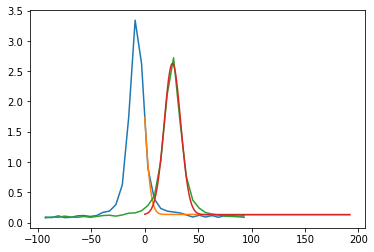

In [27]:
fig, ax = plt.subplots()
x = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["HRawProfile"][0]
y = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["HRawProfile"][1]
ax.plot(x,y)

poptH, pcovH = do_gaussian_fit(x, y)
x2 = np.linspace(0, 192, 200)
ax.plot(x2, gaussian_function(x2, poptH[0], poptH[1], poptH[2], poptH[3]))
print(f"sigma = {poptH[3]}")

x = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["VRawProfile"][0]
y = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["VRawProfile"][1]
ax.plot(x,y)

poptH, pcovH = do_gaussian_fit(x, y)
x2 = np.linspace(0, 192, 200)
ax.plot(x2, gaussian_function(x2, poptH[0], poptH[1], poptH[2], poptH[3]))
print(f"sigma = {poptH[3]}")

In [28]:
df = pd.DataFrame(data = {})
                          
for j in range(len(loaded_pickle[0])):
    df2 = pd.DataFrame(data = {"time": loaded_pickle[0][j],
                               "intensity": [loaded_pickle[3][j]],
                               "meas_pulse_qfn01": loaded_pickle[1]['F61.QFN01/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn02": loaded_pickle[1]['F61.QDN02/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qfn03": loaded_pickle[1]['F61.QFN03/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn04": loaded_pickle[1]['F61.QDN04/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qfn05": loaded_pickle[1]['T8.QFN05/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn06": loaded_pickle[1]['T8.QDN06/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn07": loaded_pickle[1]['T8.QDN07/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qfn08": loaded_pickle[1]['T8.QFN08/MEAS.PULSE#VALUE'][j],
                               "k_qfn01": loaded_pickle[2]['logical.F61.QFN01/K_FUNC_LIST#value'][j][0][1][0],
                               "k_qdn02": loaded_pickle[2]["logical.F61.QDN02/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qfn03": loaded_pickle[2]["logical.F61.QFN03/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qdn04": loaded_pickle[2]['logical.F61.QDN04/K_FUNC_LIST#value'][j][0][1][0],
                               "k_qfn05": loaded_pickle[6]["logical.T8.QFN05/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qdn06": loaded_pickle[6]["logical.T8.QDN06/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qdn07": loaded_pickle[6]["logical.T8.QDN07/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qfn08": loaded_pickle[6]["logical.T8.QFN08/K_FUNC_LIST#value"][j][0][1][0],
#                                "blm008": loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence'][j],
#                                "blm027": loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence'][j],
#                                "blm002": loaded_pickle[9]['F62.BLM002/Acquisition#lossBeamPresence'][j],
#                                "blm003": loaded_pickle[9]['F63.BLM003/Acquisition#lossBeamPresence'][j],
#                                "blm006": loaded_pickle[9]['T08.BLM006/Acquisition#lossBeamPresence'][j],
#                                "blm023": loaded_pickle[9]['T08.BLM023/Acquisition#lossBeamPresence'][j],
#                                "blm045": loaded_pickle[9]['T08.BLM045/Acquisition#lossBeamPresence'][j],
#                                "blm060": loaded_pickle[9]['T08.BLM060/Acquisition#lossBeamPresence'][j],
#                                "blm067": loaded_pickle[9]['T08.BLM067/Acquisition#lossBeamPresence'][j],
#                                "mwpc_HRawProfile": loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][j]["HRawProfile"],
                                "mwpc_HSigma": loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][j]["HSigma"],
                                "mwpc_VSigma": loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][j]["VSigma"],
                               "bpm01H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions'][j]["HSigma"],
                               "bpm01V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions'][j]["VSigma"],
                               "bpm02H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions'][j]["HSigma"],
                               "bpm02V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions'][j]["VSigma"],
                               "bpm03H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions'][j]["HSigma"],
                               "bpm03V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions'][j]["VSigma"],
                               "bpm04H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions'][j]["HSigma"],
                               "bpm04V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions'][j]["VSigma"],
                              })

    df = pd.concat([df,df2])
df.reset_index(drop=True, inplace=True)

In [29]:
df.head(1)

time  intensity  meas_pulse_qfn01  meas_pulse_qdn02  \
0 2022-07-27 17:01:52.872202  19.808887        624.080078        405.934692   

   meas_pulse_qfn03  meas_pulse_qdn04  meas_pulse_qfn05  meas_pulse_qdn06  \
0        381.210419        166.327713        374.575745         371.48584   

   meas_pulse_qdn07  meas_pulse_qfn08  ...  mwpc_HSigma  mwpc_VSigma  \
0        178.863739        291.715424  ...     6.463321     7.745704   

     bpm01H    bpm01V    bpm02H    bpm02V    bpm03H    bpm03V   bpm04H  \
0  3.960909  4.348291  3.305577  7.383789  2.616411  0.557427  4.63282   

     bpm04V  
0  9.912946  

[1 rows x 28 columns]

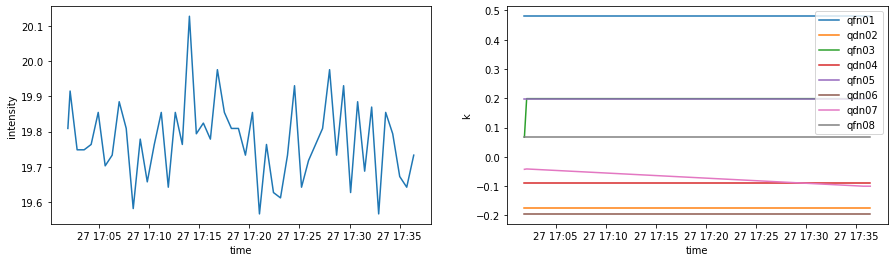

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df.time, df.intensity)
ax[0].set_xlabel("time")
ax[0].set_ylabel("intensity")
ax[1].plot(df.time, df.k_qfn01, label="qfn01")
ax[1].plot(df.time, df.k_qdn02, label="qdn02")
ax[1].plot(df.time, df.k_qfn03, label="qfn03")
ax[1].plot(df.time, df.k_qdn04, label="qdn04")
ax[1].plot(df.time, df.k_qfn05, label="qfn05")
ax[1].plot(df.time, df.k_qdn06, label="qdn06")
ax[1].plot(df.time, df.k_qdn07, label="qdn07")
ax[1].plot(df.time, df.k_qfn08, label="qfn08")
ax[1].set_xlabel("time")
ax[1].set_ylabel("k")
ax[1].legend()

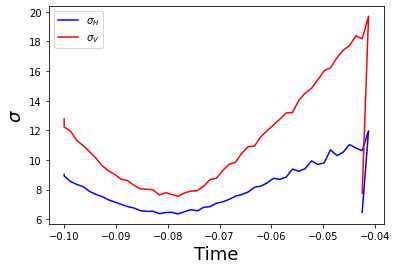

In [31]:
fig, ax = plt.subplots()
ax.plot(df.k_qdn07, df.mwpc_HSigma, color="b", label="$\sigma_{H}$")
ax.plot(df.k_qdn07, df.mwpc_VSigma, color="r", label="$\sigma_{V}$")
ax.set_xlabel("Time", fontsize=18)
ax.set_ylabel("$\sigma$", fontsize=18)
ax.legend()

In [32]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

In [33]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Old initial parameters
betx0 = 82.4
bety0 = 33.2
alfx0 = -11.1
alfy0 = 0.28
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 1.5e-06
eyn =  1.5e-06
sige = 0.001

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx_old = []
VSigma_madx_old = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx_old.append(x_beam_size)
    VSigma_madx_old.append(y_beam_size)

(-0.1, 0.1)

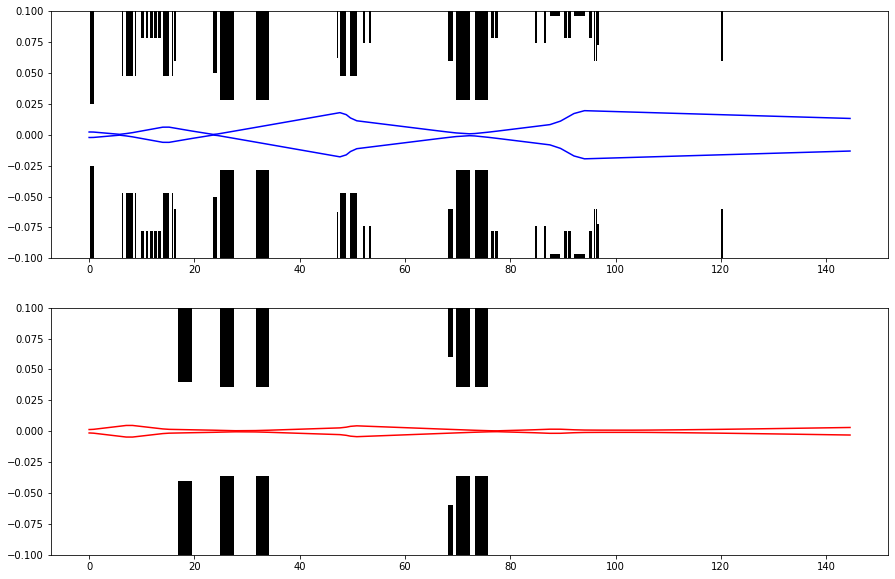

In [34]:
fig, ax = plt.subplots(2,1, figsize=(15, 10))
draw_aperture(ax[0], twiss_f61, 'aper_1')
ax[0].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), color ="b")
ax[0].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), color ="b")
ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r")
ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r")
draw_aperture(ax[1], twiss_f61, 'aper_2')
ax[0].set_ylim(-0.1, 0.1)
ax[1].set_ylim(-0.1, 0.1)

Text(0.5, 1.0, 'MWPC quadrupole scan')

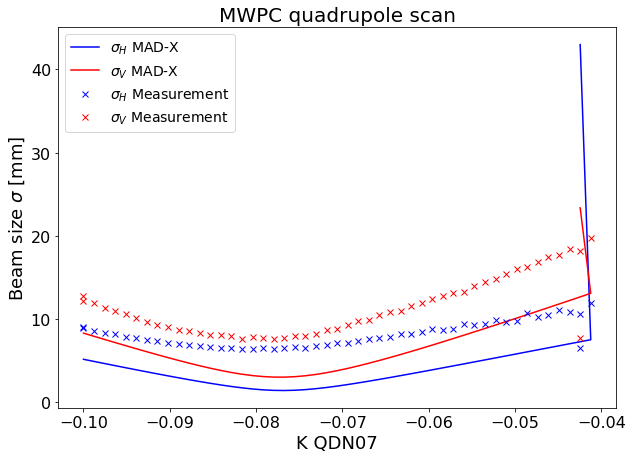

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qdn07, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qdn07, df.mwpc_HSigma, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qdn07, df.mwpc_VSigma, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
# ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("MWPC quadrupole scan", fontsize=20)

### MWPC errorbars

In [36]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 2

for i in range(len(loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

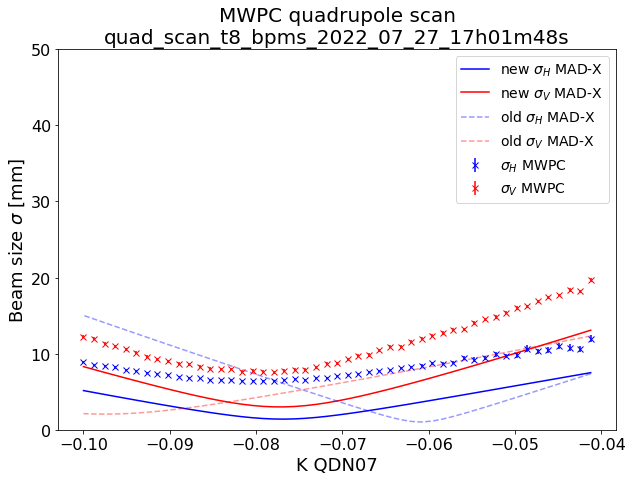

In [37]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qdn07[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="new $\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="new $\sigma_{V}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(HSigma_madx_old[1:-1])*1000, alpha=0.4, ls="--", color="b", label="old $\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(VSigma_madx_old[1:-1])*1000, alpha=0.4, ls="--", color="r", label="old $\sigma_{V}$ MAD-X")
ax.errorbar(df.k_qdn07[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ MWPC")
ax.errorbar(df.k_qdn07[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="r",marker="x", ls="", label="$\sigma_{V}$ MWPC")
# ax.set_xlim(0.04, 0.2)
ax.set_ylim(0,50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"MWPC quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/mwpc_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

/tmp/ipykernel_904/1493656976.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


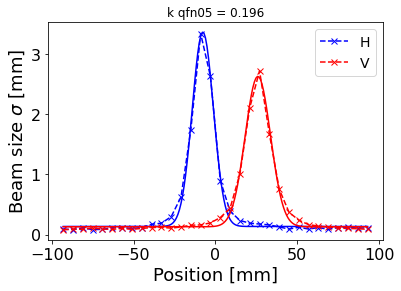

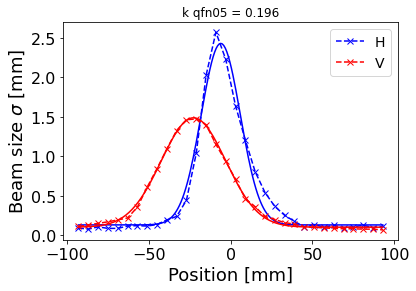

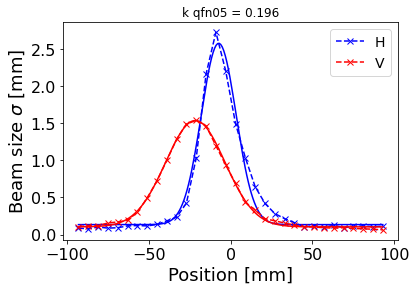

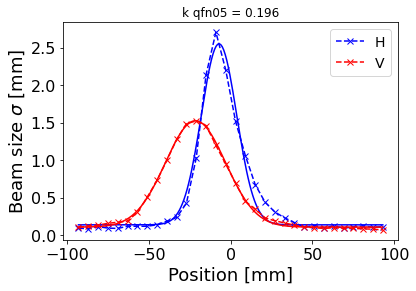

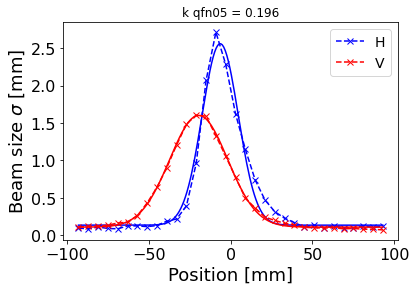

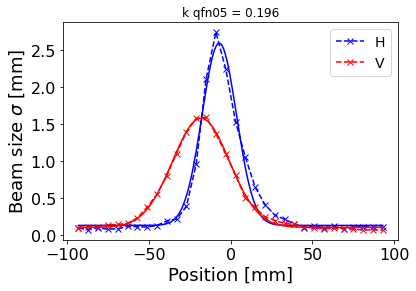

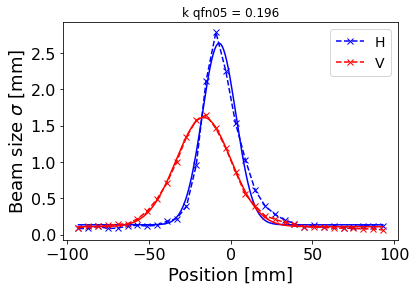

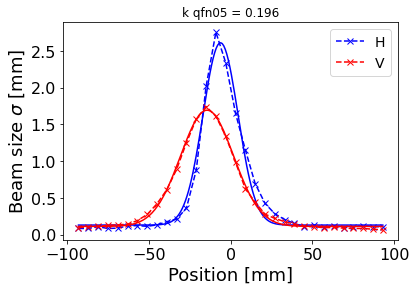

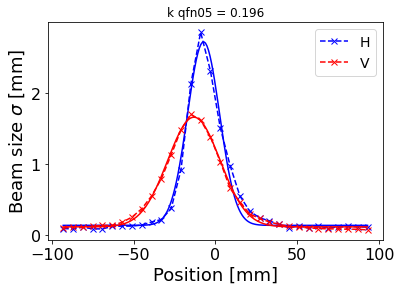

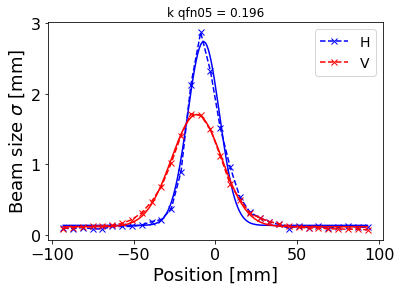

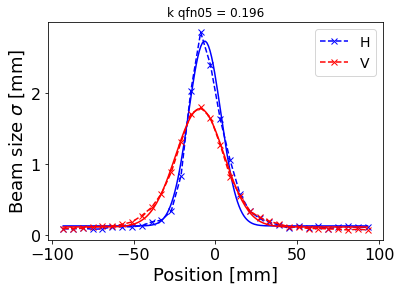

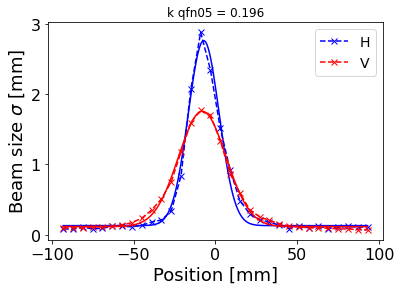

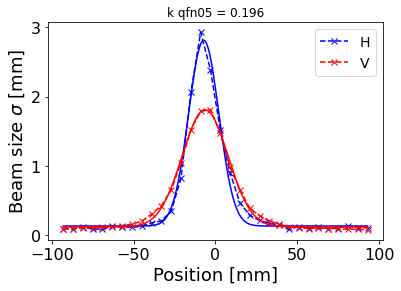

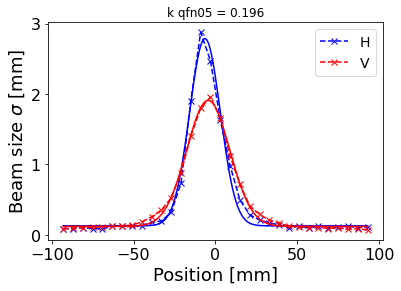

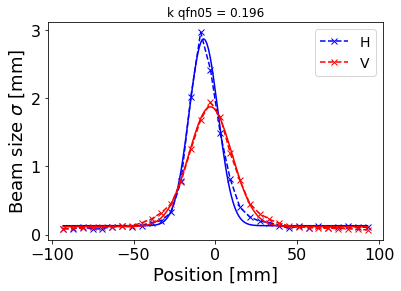

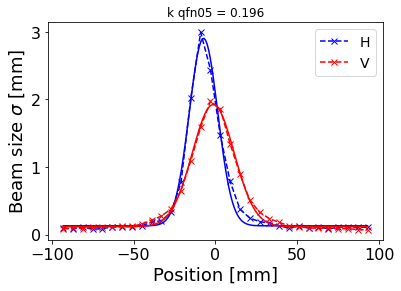

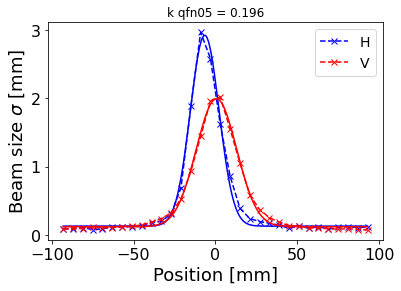

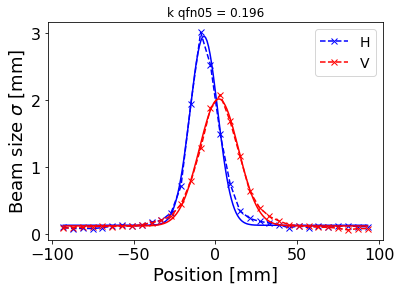

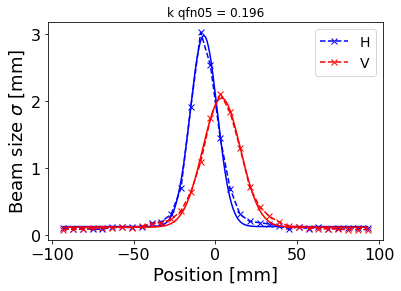

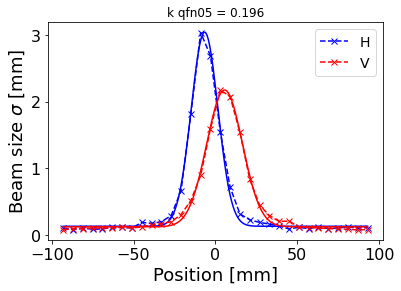

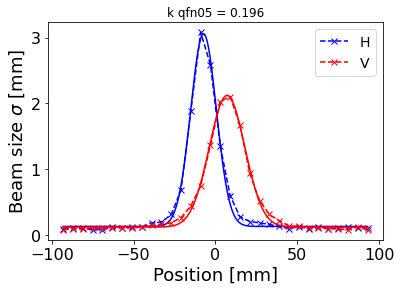

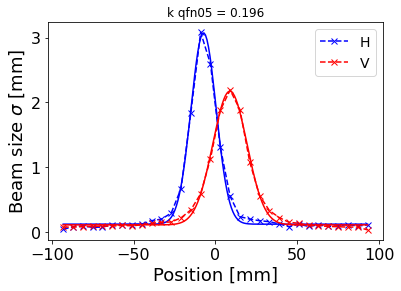

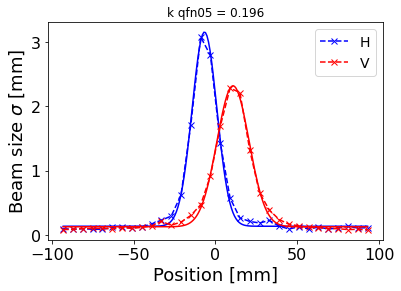

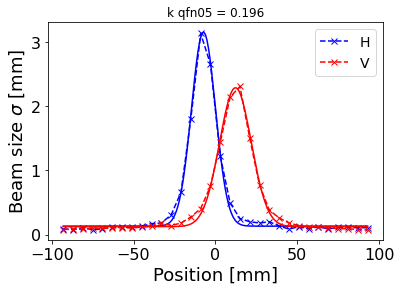

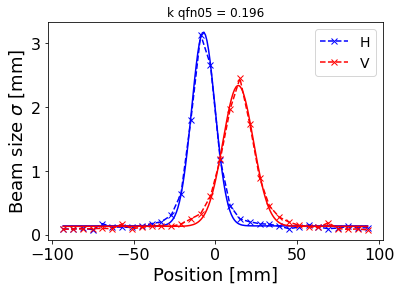

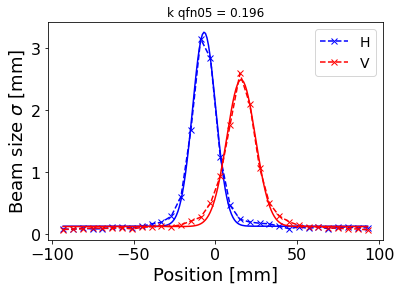

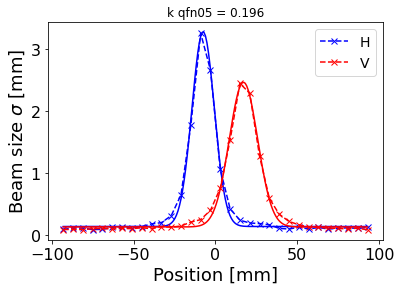

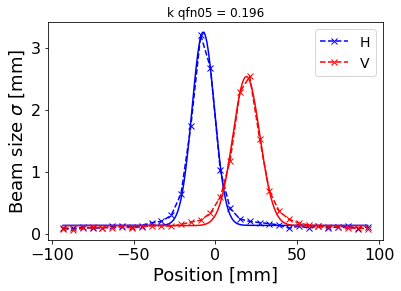

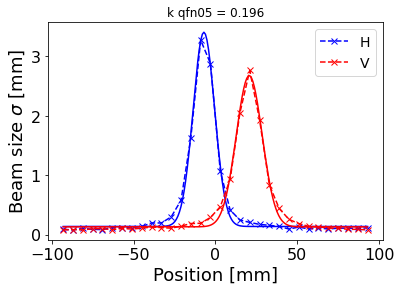

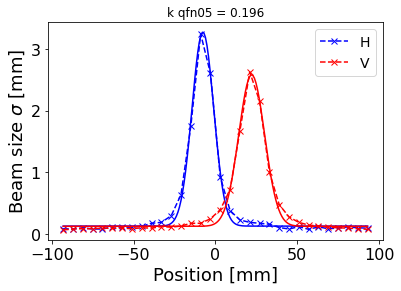

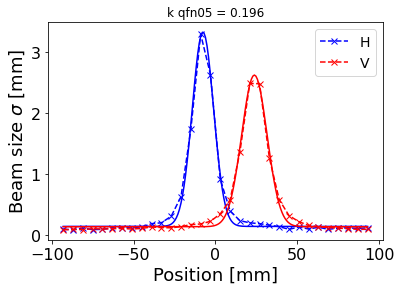

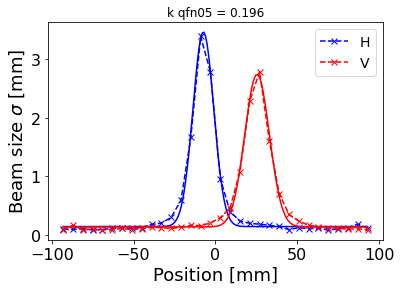

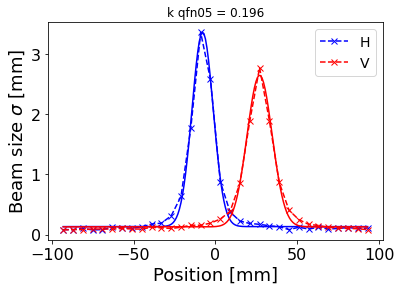

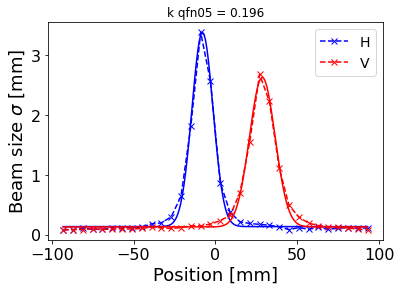

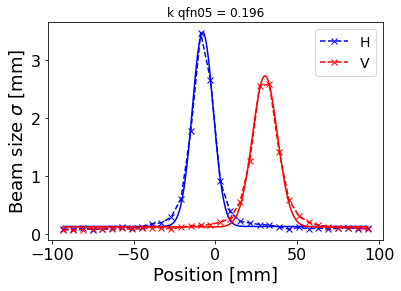

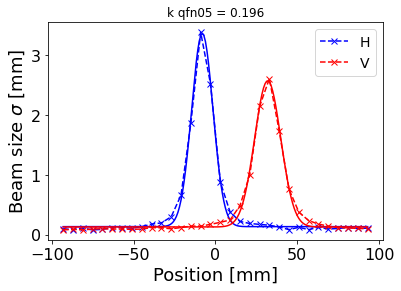

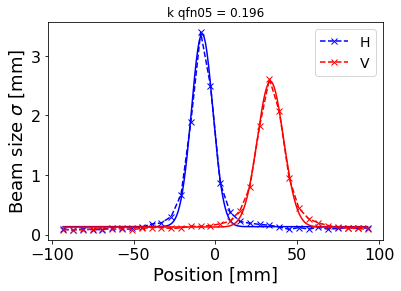

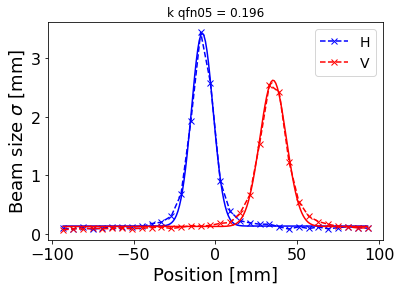

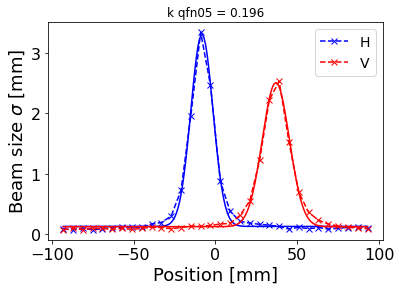

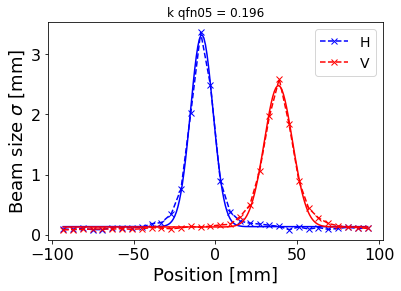

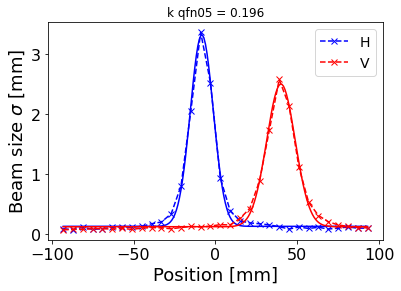

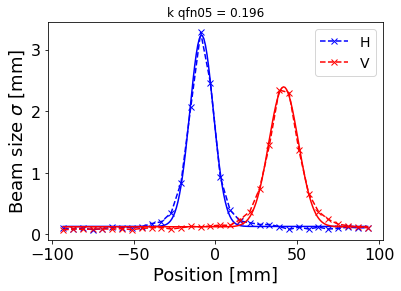

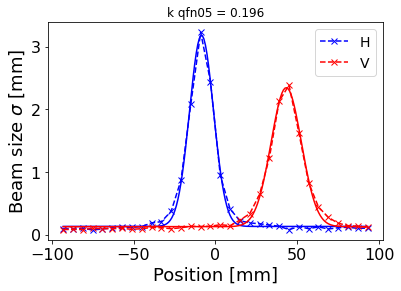

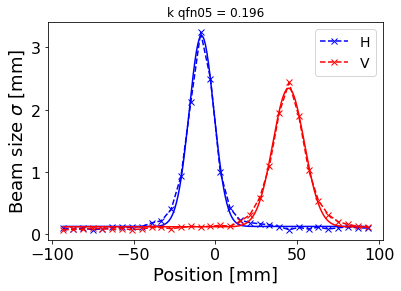

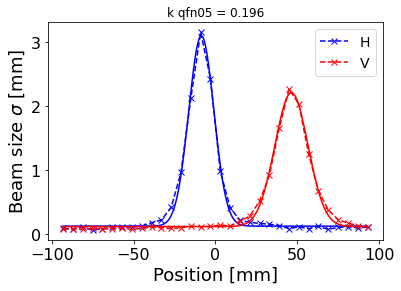

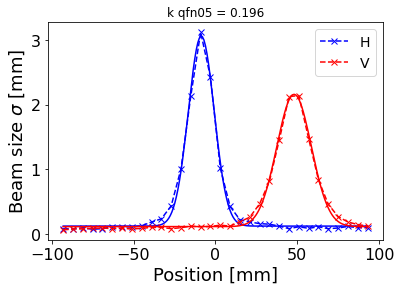

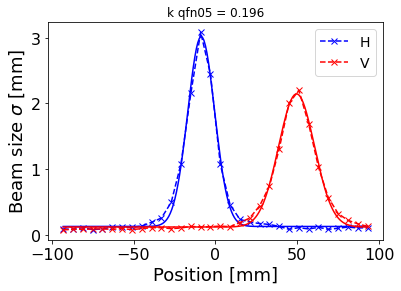

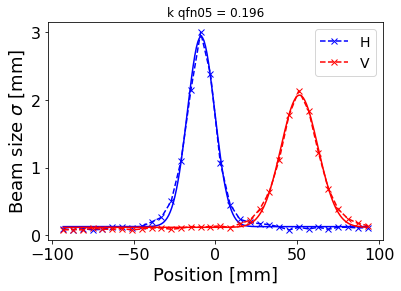

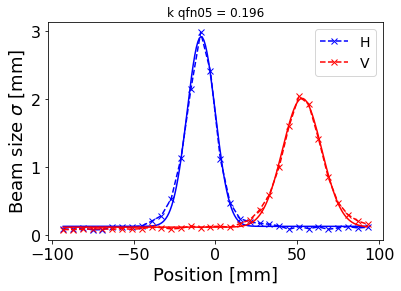

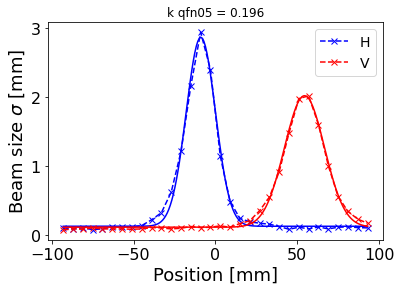

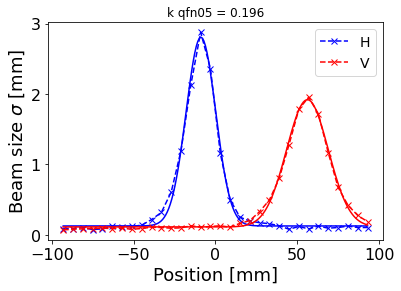

In [38]:
for i in range(len(loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"])):
    fig, ax = plt.subplots()
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    ax.plot(x,y, label="H", color="b", marker="x", ls="--")
    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)
    ax.plot(x2, gaussian_function(x2, popt[0], popt[1], popt[2], popt[3]), color="b")
        
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    ax.plot(x,y, label="V", color="r", marker="x", ls="--")
    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)
    ax.plot(x2, gaussian_function(x2, popt[0], popt[1], popt[2], popt[3]), color="r")
    ax.legend()
    ax.set_xlabel("Position [mm]", fontsize=18)
    ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
    ax.legend(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(f"k qfn05 = {round(df.iloc[i].k_qfn05,4)}")

# Create a dataframe to be used for optimising

In [39]:
df_for_optimising = pd.DataFrame(data = {
    "k_qfn01": df.k_qfn01[1:-1],
    "k_qdn02": df.k_qdn02[1:-1],
    "k_qfn03": df.k_qfn03[1:-1],
    "k_qdn04": df.k_qdn04[1:-1],
    "k_qfn05": df.k_qfn05[1:-1],
    "k_qdn06": df.k_qdn06[1:-1],
    "k_qdn07": df.k_qdn07[1:-1],
    "k_qfn08": df.k_qfn08[1:-1],
    "sigH": HSigma_refit[1:-1],
    "sigV": VSigma_refit[1:-1],
    
})
                          
df_for_optimising

k_qfn01  k_qdn02  k_qfn03  k_qdn04  k_qfn05  k_qdn06   k_qdn07  k_qfn08  \
1   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.041224  0.06721   
2   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.042449  0.06721   
3   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.043673  0.06721   
4   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.044898  0.06721   
5   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.046122  0.06721   
6   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.047347  0.06721   
7   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.048571  0.06721   
8   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.049796  0.06721   
9   0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.051020  0.06721   
10  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.052245  0.06721   
11  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.053469  0.06721   
12  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.054694  0.06721   
13  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.055918  0.06721   
14  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.057143  0.06721   
15  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.058367  0.06721   
16  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.059592  0.06721   
17  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.060816  0.06721   
18  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.062041  0.06721   
19  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.063265  0.06721   
20  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.064490  0.06721   
21  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.065714  0.06721   
22  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.066939  0.06721   
23  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.068163  0.06721   
24  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.069388  0.06721   
25  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.070612  0.06721   
26  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.071837  0.06721   
27  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.073061  0.06721   
28  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.074286  0.06721   
29  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.075510  0.06721   
30  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.076735  0.06721   
31  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.077959  0.06721   
32  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.079184  0.06721   
33  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.080408  0.06721   
34  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.081633  0.06721   
35  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.082857  0.06721   
36  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.084082  0.06721   
37  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.085306  0.06721   
38  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.086531  0.06721   
39  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.087755  0.06721   
40  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.088980  0.06721   
41  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.090204  0.06721   
42  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.091429  0.06721   
43  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.092653  0.06721   
44  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.093878  0.06721   
45  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.095102  0.06721   
46  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.096327  0.06721   
47  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.097551  0.06721   
48  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.098776  0.06721   
49  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.100000  0.06721   

         sigH       sigV  
1   11.960975  19.702300  

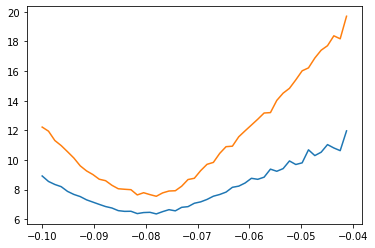

In [40]:
fig, ax = plt.subplots()
ax.plot(df_for_optimising.k_qdn07, df_for_optimising.sigH)
ax.plot(df_for_optimising.k_qdn07, df_for_optimising.sigV)

In [41]:
with open('../df/t8/df_'+str(subset_dirnames[0])+'.pickle', 'wb') as handle:
        pickle.dump(df_for_optimising, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
pwd

'/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/mwpc_and_bpms_quad_scan'

### BLM

In [43]:
blm008=loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence']
blm027=loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence']
blm002=loaded_pickle[9]['F62.BLM002/Acquisition#lossBeamPresence']
blm003=loaded_pickle[9]['F63.BLM003/Acquisition#lossBeamPresence']
blm006=loaded_pickle[9]['T08.BLM006/Acquisition#lossBeamPresence']
blm023=loaded_pickle[9]['T08.BLM023/Acquisition#lossBeamPresence']
blm045=loaded_pickle[9]['T08.BLM045/Acquisition#lossBeamPresence']
blm060=loaded_pickle[9]['T08.BLM060/Acquisition#lossBeamPresence']
blm067=loaded_pickle[9]['T08.BLM067/Acquisition#lossBeamPresence']

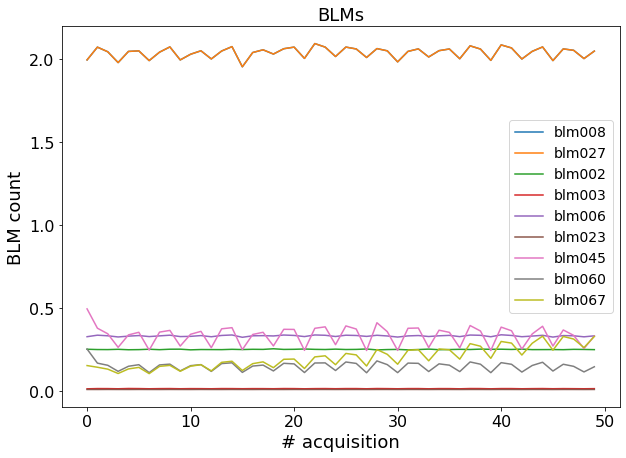

In [44]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(blm008, label="blm008")
ax.plot(blm027, label="blm027")
ax.plot(blm002, label="blm002")
ax.plot(blm003, label="blm003")
ax.plot(blm006, label="blm006")
ax.plot(blm023, label="blm023")
ax.plot(blm045, label="blm045")
ax.plot(blm060, label="blm060")
ax.plot(blm067, label="blm067")
# ax.set_ylim(0,4)
ax.set_xlabel("# acquisition", fontsize=18)
ax.set_ylabel("BLM count", fontsize=18)
ax.set_title("BLMs", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)

### XSEC

In [45]:
xsec023_I1 = loaded_pickle[10]['F61.XSEC023-I1/Acquisition#semNormData']
xsec023_I2= loaded_pickle[10]['F61.XSEC023-I2/Acquisition#semNormData']
xsec070 = loaded_pickle[10]['T08.XSEC070-I/Acquisition#semNormData']
xsec094 = loaded_pickle[10]['T08.XSEC094-I/Acquisition#semNormData']

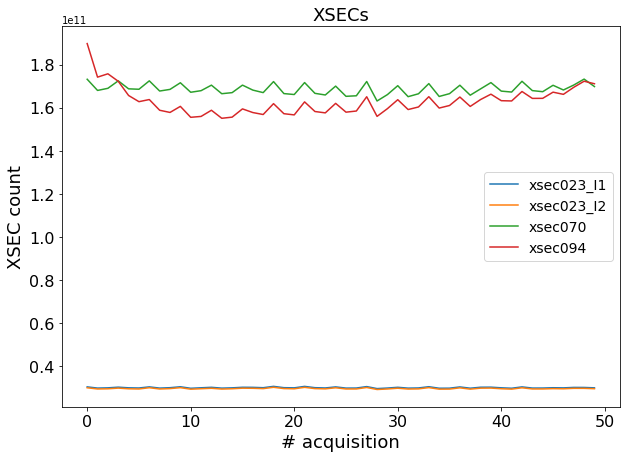

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(xsec023_I1, label="xsec023_I1")
ax.plot(xsec023_I2, label="xsec023_I2")
ax.plot(xsec070, label="xsec070")
ax.plot(xsec094, label="xsec094")
ax.legend()
ax.set_xlabel("# acquisition", fontsize=18)
ax.set_ylabel("XSEC count", fontsize=18)
ax.set_title("XSECs", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)

## BPM

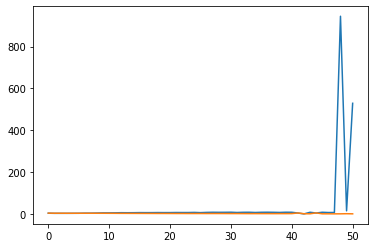

In [47]:
fig, ax = plt.subplots()
ax.plot(df.bpm01H)
ax.plot(df.bpm01V)

#### BPM01

In [48]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.bpm073"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

Text(0.5, 1.0, 'BPM01 quadrupole scan')

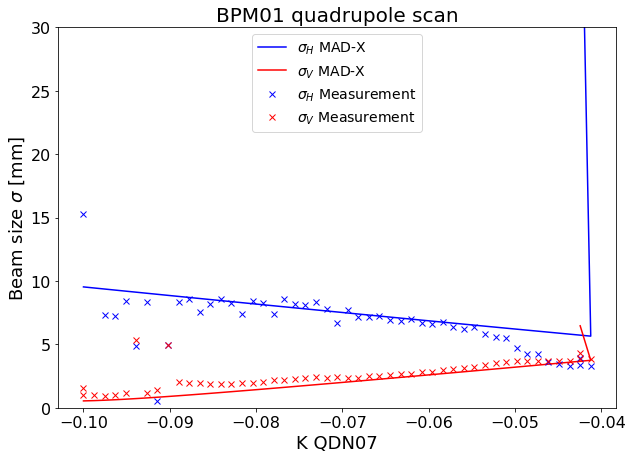

In [49]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qdn07, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qdn07, df.bpm01H, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qdn07, df.bpm01V, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("BPM01 quadrupole scan", fontsize=20)

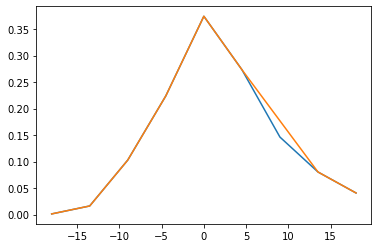

In [50]:
i = 0
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 6)
y = np.delete(y, 6)
ax.plot(x,y)

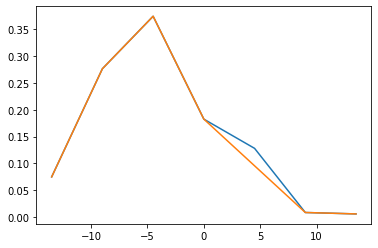

In [51]:
i = 0
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 4)
y = np.delete(y, 4)
ax.plot(x,y)

In [52]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 2

for i in range(len(loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 6)
    y = np.delete(y, 6)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

/tmp/ipykernel_904/1862854246.py:78: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:


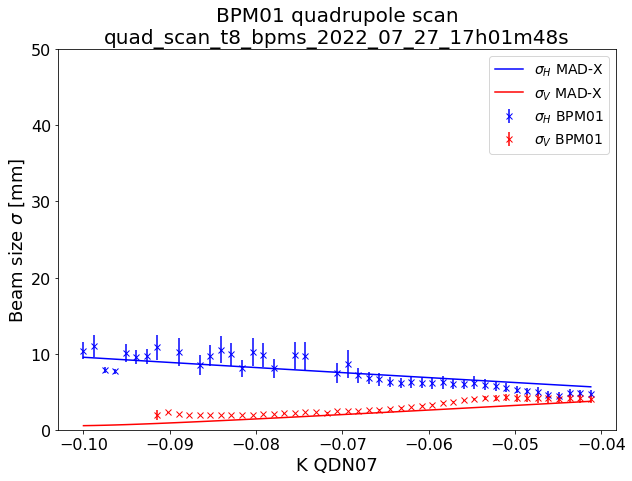

In [53]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qdn07[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.errorbar(df.k_qdn07[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01")
# ax.errorbar(df.k_qdn07, np.array(HSigma_refit_pts_removed), HSigma_err_pts_removed, color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads column 6 removed)")
ax.errorbar(df.k_qdn07[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="r",marker="x", ls="", label="$\sigma_{V}$ BPM01")
# ax.errorbar(df.k_qdn07, np.array(VSigma_refit_pts_removed), VSigma_err_pts_removed, color="r", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads row 4 removed)")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"BPM01 quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/bpm01_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

### BPM2

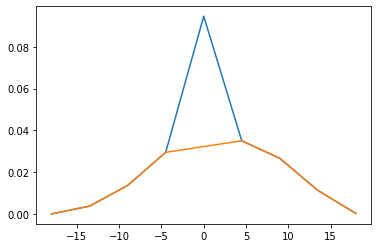

In [54]:
i = 50
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 4)
y = np.delete(y, 4)
ax.plot(x,y)

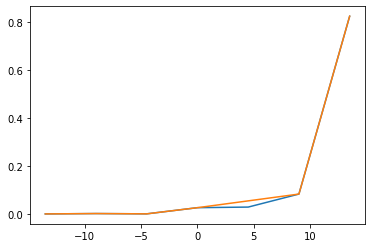

In [55]:
i = 40
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 4)
y = np.delete(y, 4)
ax.plot(x,y)

In [56]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.bpm080"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

Text(0.5, 1.0, 'BPM02 quadrupole scan')

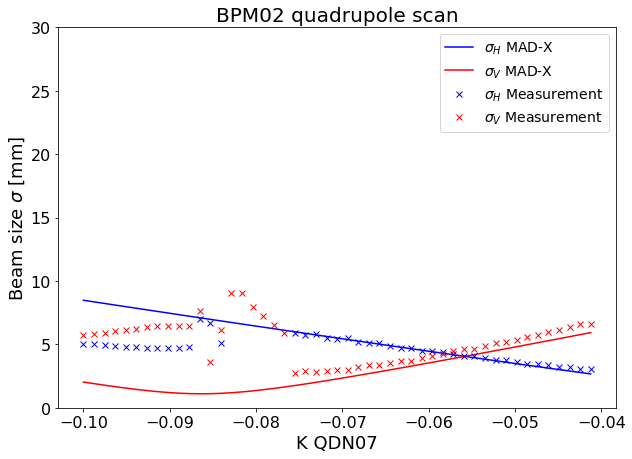

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qdn07[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], df.bpm02H[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qdn07[1:-1], df.bpm02V[1:-1], color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("BPM02 quadrupole scan", fontsize=20)

In [58]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 1

for i in range(len(loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

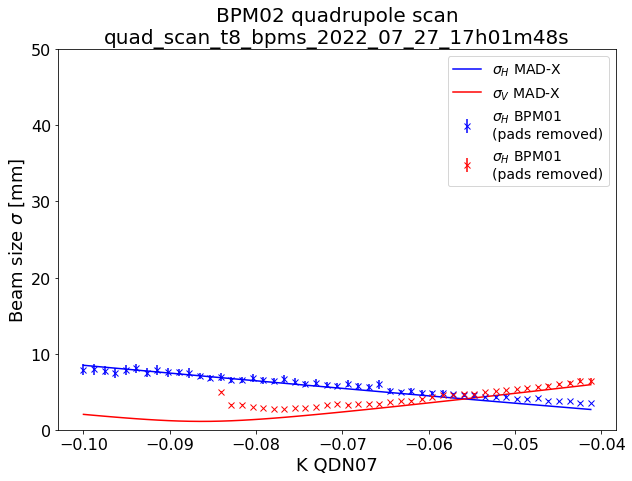

In [59]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qdn07[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
# ax.errorbar(df.k_qdn07[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="darkblue", marker="x", ls="", label="$\sigma_{H}$ BPM01")
ax.errorbar(df.k_qdn07[1:-1], np.array(HSigma_refit_pts_removed[1:-1]), HSigma_err_pts_removed[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads removed)")
# ax.errorbar(df.k_qdn07[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="darkred",marker="x", ls="", label="$\sigma_{V}$ BPM01")
ax.errorbar(df.k_qdn07[1:-1], np.array(VSigma_refit_pts_removed[1:-1]), VSigma_err_pts_removed[1:-1], color="r", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads removed)")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"BPM02 quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/bpm02_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

### BPM04

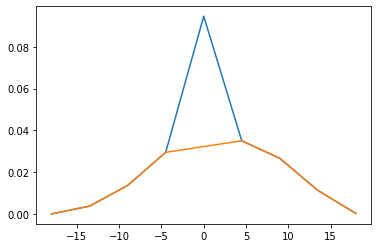

In [60]:
i = 50
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 4)
y = np.delete(y, 4)
ax.plot(x,y)

In [61]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.bpm092"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

Text(0.5, 1.0, 'BPM04 quadrupole scan')

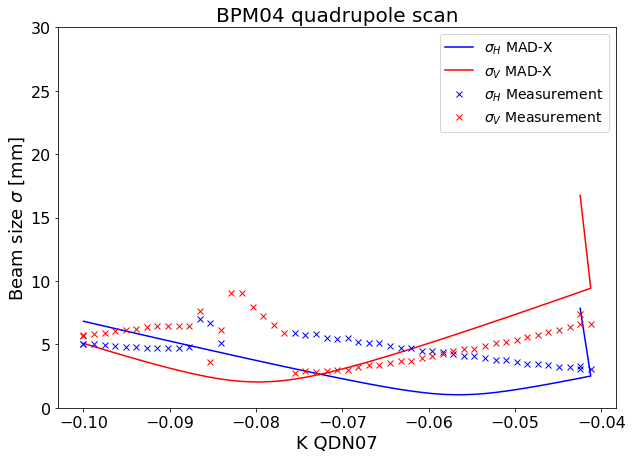

In [62]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qdn07, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qdn07, df.bpm02H, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qdn07, df.bpm02V, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("BPM04 quadrupole scan", fontsize=20)

In [63]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 1

for i in range(len(loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

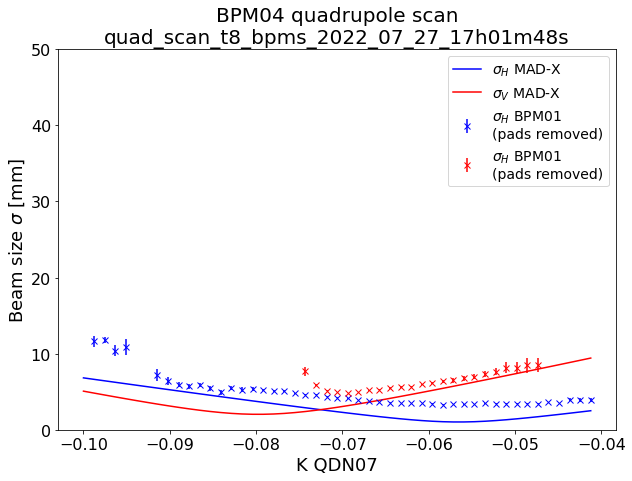

In [64]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qdn07[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qdn07[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
# ax.errorbar(df.k_qdn07[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="darkblue", marker="x", ls="", label="$\sigma_{H}$ BPM01")
ax.errorbar(df.k_qdn07[1:-1], np.array(HSigma_refit_pts_removed[1:-1]), HSigma_err_pts_removed[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads removed)")
# ax.errorbar(df.k_qdn07[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="darkred",marker="x", ls="", label="$\sigma_{V}$ BPM01")
ax.errorbar(df.k_qdn07[1:-1], np.array(VSigma_refit_pts_removed[1:-1]), VSigma_err_pts_removed[1:-1], color="r", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads removed)")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0, 50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"BPM04 quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/bpm04_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

# Gif of the BLM as a function of beam size

<IPython.core.display.Javascript object>


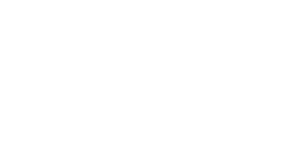

In [65]:
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
fig,ax = plt.subplots(3,1, figsize=(15,10))
def animate(i):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()

    ax[0].bar(34, blm006[i], label="T08 blm006")
    ax[0].bar(50, blm023[i], label="T08 blm023")
    ax[0].bar(72, blm045[i], label="T08 blm045")
    ax[0].bar(89, blm060[i], label="T08 blm060")
    ax[0].bar(94, blm067[i], label="T08 blm067")

    ax[0].legend(loc="upper left")
    ax[0].set_ylim(0,100)
    ax[0].set_xlim(0, 144.5)
    ax[1].set_xlim(0, 144.5)
    ax[2].set_xlim(0, 144.5)
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)


    draw_aperture(ax[1], twiss_f61, 'aper_1')
    ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b", zorder=0)
    ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b", zorder=0)
    ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
    ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
    
    ax[1].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[1].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[1].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[1].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 6)
    y = np.delete(y, 6)
    ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm073"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
    ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm080"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]
    ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm092"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    ax[1].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)/1000, color="orange")
    
    ax[1].set_ylim(-0.1, 0.1)
    
    draw_aperture(ax[2], twiss_f61, 'aper_2')
    ax[2].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r", zorder=0)
    ax[2].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r", zorder=0)
    ax[2].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r", zorder=0)
    ax[2].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r", zorder=0)
    ax[2].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[2].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[2].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[2].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[2].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[2].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[2].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    ax[2].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm073"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    ax[2].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm080"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    ax[2].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm092"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    ax[2].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)/1000, color="orange")
    
    ax[2].set_ylim(-0.1, 0.1)
    
    return
        
ani = FuncAnimation(fig, animate, interval=200, blit=True, repeat=False, frames=len(blm008))
# ani.save("gif/quad_scan_focal_mwpc_no_screen_in.gif", dpi=100, writer=PillowWriter(fps=5))

# Gif of the animation but why the centroid substracted from the raw data

<IPython.core.display.Javascript object>


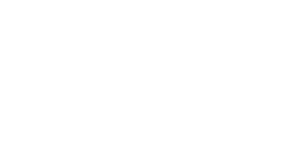

/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/matplotlib/animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [66]:
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
error_threshold = 2
fig,ax = plt.subplots(2,1, figsize=(15,10))
def animate(i):
    ax[0].clear()
    ax[1].clear()

    ax[0].set_xlim(80, 144.5)
    ax[1].set_xlim(80, 144.5)
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)


    draw_aperture(ax[0], twiss_f61, 'aper_1')
    ax[0].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b", zorder=0)
    ax[0].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b", zorder=0)
    ax[0].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
    ax[0].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
    
    ax[0].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[0].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[0].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[0].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[0].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[0].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[0].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 6)
    y = np.delete(y, 6)
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm073"], x2, color="darkgreen")
            ax[0].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm073"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            ax[0].hlines(popt[3], xmin=twiss_f61['s']["t08.bpm073"], xmax = twiss_f61['s']["t08.bpm073"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
            ax[0].hlines(-popt[3], xmin=twiss_f61['s']["t08.bpm073"], xmax = twiss_f61['s']["t08.bpm073"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm080"], x2, color="darkgreen")
            ax[0].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm080"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            ax[0].hlines(popt[3], xmin=twiss_f61['s']["t08.bpm080"], xmax = twiss_f61['s']["t08.bpm080"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
            ax[0].hlines(-popt[3], xmin=twiss_f61['s']["t08.bpm080"], xmax = twiss_f61['s']["t08.bpm080"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm092"], x2, color="darkgreen")
            ax[0].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm092"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            ax[0].hlines(popt[3], xmin=twiss_f61['s']["t08.bpm092"], xmax = twiss_f61['s']["t08.bpm092"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
            ax[0].hlines(-popt[3], xmin=twiss_f61['s']["t08.bpm092"], xmax = twiss_f61['s']["t08.bpm092"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
    except:
        pass
    
    #MWPC H
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    
    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)/1000
    ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*5 + twiss_f61['s']["t08.xwcm103"], x2, color="darkorange")
    ax[0].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)-popt[2], marker="x", ls = "", color="orange")
    ax[0].hlines(popt[3], xmin=twiss_f61['s']["t08.xwcm103"], xmax = twiss_f61['s']["t08.xwcm103"]+5*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkorange")
    ax[0].hlines(-popt[3], xmin=twiss_f61['s']["t08.xwcm103"], xmax = twiss_f61['s']["t08.xwcm103"]+5*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkorange")
    
    ax[0].set_ylim(-0.05, 0.05)
    
    draw_aperture(ax[1], twiss_f61, 'aper_2')
    ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r", zorder=0)
    ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r", zorder=0)
    ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r", zorder=0)
    ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r", zorder=0)
    ax[1].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[1].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[1].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[1].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[1].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm073"], x2, color="darkgreen")
            ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm073"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            ax[1].hlines(popt[3], xmin=twiss_f61['s']["t08.bpm073"], xmax = twiss_f61['s']["t08.bpm073"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
            ax[1].hlines(-popt[3], xmin=twiss_f61['s']["t08.bpm073"], xmax = twiss_f61['s']["t08.bpm073"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[1].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm080"], x2, color="darkgreen")
            ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm080"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            ax[1].hlines(popt[3], xmin=twiss_f61['s']["t08.bpm080"], xmax = twiss_f61['s']["t08.bpm080"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
            ax[1].hlines(-popt[3], xmin=twiss_f61['s']["t08.bpm080"], xmax = twiss_f61['s']["t08.bpm080"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[1].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm092"], x2, color="darkgreen")
            ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm092"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            ax[1].hlines(popt[3], xmin=twiss_f61['s']["t08.bpm092"], xmax = twiss_f61['s']["t08.bpm092"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
            ax[1].hlines(-popt[3], xmin=twiss_f61['s']["t08.bpm092"], xmax = twiss_f61['s']["t08.bpm092"]+10*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkgreen")
    except:
        pass
    
    #MWPC V
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]

    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)/1000
    ax[1].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*5 + twiss_f61['s']["t08.xwcm103"], x2, color="darkorange")
    ax[1].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)-popt[2], marker="x", ls = "", color="orange")
    ax[1].hlines(popt[3], xmin=twiss_f61['s']["t08.xwcm103"], xmax = twiss_f61['s']["t08.xwcm103"]+5*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkorange")
    ax[1].hlines(-popt[3], xmin=twiss_f61['s']["t08.xwcm103"], xmax = twiss_f61['s']["t08.xwcm103"]+5*gaussian_function(popt[3]+popt[2], popt[0], popt[1], popt[2], popt[3]), color="darkorange")
    
    ax[1].set_ylim(-0.05, 0.05)
    
    return
        
ani = FuncAnimation(fig, animate, interval=20, blit=True, repeat=False, frames=len(blm008))
# ani.save("gif/quad_scan_focal_mwpc_no_screen_in_with_mean_substraction.gif", dpi=100, writer=PillowWriter(fps=5))

# Gif with MAD-X following beam center

<IPython.core.display.Javascript object>


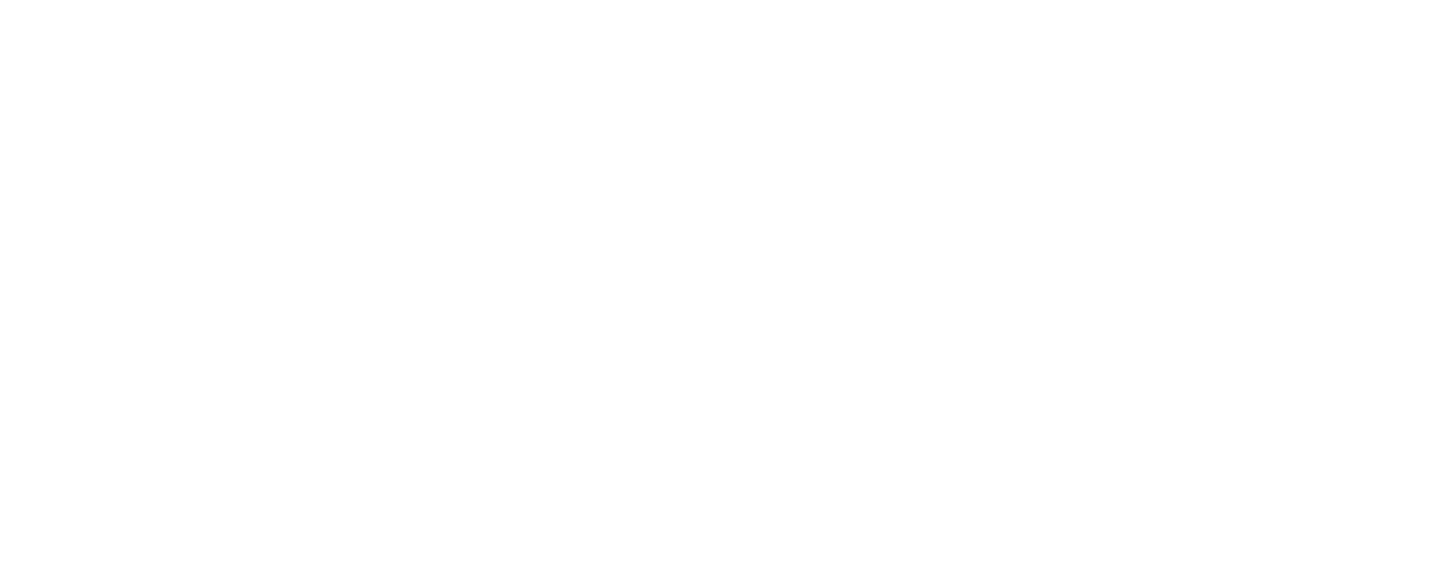

/tmp/ipykernel_904/896519372.py:166: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:
/tmp/ipykernel_904/896519372.py:166: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:
/tmp/ipykernel_904/896519372.py:166: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:
/tmp/ipykernel_904/896519372.py:166: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:
/tmp/ipykernel_904/896519372.py:166: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:


In [67]:
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
error_threshold = 2
fig,ax = plt.subplots(2,1, figsize=(20,8), tight_layout=True)
def animate(i):
    ax[0].clear()
    ax[1].clear()

    ax[0].set_xlim(0, 144.5)
    ax[1].set_xlim(0, 144.5)
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

    draw_aperture(ax[0], twiss_f61, 'aper_1')
    sigH_madx_p = beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1)
    sigH_madx_p = sigH_madx_p.drop(sigH_madx_p.keys()[~sigH_madx_p.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
    sigH_madx_m = -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1)
    sigH_madx_m = sigH_madx_m.drop(sigH_madx_m.keys()[~sigH_madx_m.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
    s = twiss_f61['s']
    s = s.drop(s.keys()[~s.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
    
    ax[0].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[0].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")
    
    ax[0].axvline(twiss_f61.s["t08.mqnfk061"], linestyle = "--", color = "darkcyan")

    ax[0].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[0].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[0].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[0].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[0].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[0].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 6)
    y = np.delete(y, 6)
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm073"], x2, color="darkgreen")
            ax[0].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm073"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            sigH_madx_p["t08.bpm073"] = sigH_madx_p["t08.bpm073"] - popt[2]
            sigH_madx_m["t08.bpm073"] = sigH_madx_m["t08.bpm073"] - popt[2]
        else:
            sigH_madx_p["t08.bpm073"] = np.nan
            sigH_madx_m["t08.bpm073"] = np.nan
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm080"], x2, color="darkgreen")
            ax[0].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm080"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            sigH_madx_p["t08.bpm080"] = sigH_madx_p["t08.bpm080"] - popt[2]
            sigH_madx_m["t08.bpm080"] = sigH_madx_m["t08.bpm080"] - popt[2]
        else:
            sigH_madx_p["t08.bpm080"] = np.nan
            sigH_madx_m["t08.bpm080"] = np.nan
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm092"], x2, color="darkgreen")
            ax[0].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm092"],np.array(x)-popt[2], marker="x", ls = "", color="green")
            sigH_madx_p["t08.bpm092"] = sigH_madx_p["t08.bpm092"] - popt[2]
            sigH_madx_m["t08.bpm092"] = sigH_madx_m["t08.bpm092"] - popt[2]
        else:
            sigH_madx_p["t08.bpm092"] = np.nan
            sigH_madx_m["t08.bpm092"] = np.nan
    except:
        pass
    
    #MWPC H
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]/1000
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    
    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)/1000
    ax[0].plot(gaussian_function(x2+popt[2], popt[0], popt[1], popt[2], popt[3])*5 + twiss_f61['s']["t08.xwcm103"], x2, color="darkorange")
    ax[0].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)-popt[2], marker="x", ls = "", color="orange")
    sigH_madx_p["t08.xwcm103"] = sigH_madx_p["t08.xwcm103"] + popt[2]
    sigH_madx_m["t08.xwcm103"] = sigH_madx_m["t08.xwcm103"] + popt[2]
    
    ax[0].plot(s, sigH_madx_p, color ="b", zorder=99)
    ax[0].plot(s, sigH_madx_m, color ="b", zorder=99)
    ax[0].set_ylim(-0.1, 0.1)
    ax[0].set_ylabel("H position [m]")
    
    draw_aperture(ax[1], twiss_f61, 'aper_2')
    sigV_madx_p = beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1)
    sigV_madx_p = sigV_madx_p.drop(sigV_madx_p.keys()[~sigV_madx_p.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
    sigV_madx_m = -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1)
    sigV_madx_m = sigV_madx_m.drop(sigV_madx_m.keys()[~sigV_madx_m.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])

    ax[1].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[1].axvline(twiss_f61.s["t08.mqnfk061"], linestyle = "--", color = "darkcyan", label="QDN07")
    
    ax[1].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g", label="IRRAD BPMs")
    ax[1].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[1].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange", label="MWPC")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[1].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[1].plot(gaussian_function(x2, popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm073"], x2, color="darkgreen")
            ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm073"],np.array(x), marker="x", ls = "", color="green")
            sigV_madx_p["t08.bpm073"] = sigV_madx_p["t08.bpm073"] + popt[2]
            sigV_madx_m["t08.bpm073"] = sigV_madx_m["t08.bpm073"] + popt[2]
        else:
            sigV_madx_p["t08.bpm073"] = np.nan
            sigV_madx_m["t08.bpm073"] = np.nan
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[1].plot(gaussian_function(x2, popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm080"], x2, color="darkgreen")
            ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm080"],np.array(x), marker="x", ls = "", color="green")
            sigV_madx_p["t08.bpm080"] = sigV_madx_p["t08.bpm080"] + popt[2]
            sigV_madx_m["t08.bpm080"] = sigV_madx_m["t08.bpm080"] + popt[2]
        else:
            sigV_madx_p["t08.bpm080"] = np.nan
            sigV_madx_m["t08.bpm080"] = np.nan
    except:
        pass
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-13.5, 13.5, 200)/1000
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            ax[1].plot(gaussian_function(x2, popt[0], popt[1], popt[2], popt[3])*10 + twiss_f61['s']["t08.bpm092"], x2, color="darkgreen")
            ax[1].plot(np.array(y)*10 + twiss_f61['s']["t08.bpm092"],np.array(x), marker="x", ls = "", color="green")
            sigV_madx_p["t08.bpm092"] = sigV_madx_p["t08.bpm092"] + popt[2]
            sigV_madx_m["t08.bpm092"] = sigV_madx_m["t08.bpm092"] + popt[2]
        else:
            sigV_madx_p["t08.bpm092"] = np.nan
            sigV_madx_m["t08.bpm092"] = np.nan
    except:
        pass
    
    #MWPC V
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]/1000
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]

    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)/1000
    ax[1].plot(gaussian_function(x2, popt[0], popt[1], popt[2], popt[3])*5 + twiss_f61['s']["t08.xwcm103"], x2, color="darkorange")
    ax[1].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x), marker="x", ls = "", color="orange")
    sigV_madx_p["t08.xwcm103"] = sigV_madx_p["t08.xwcm103"] + popt[2]
    sigV_madx_m["t08.xwcm103"] = sigV_madx_m["t08.xwcm103"] + popt[2]
    
    ax[1].plot(s, sigV_madx_p, color ="r", zorder=99)
    ax[1].plot(s, sigV_madx_m, color ="r", zorder=99)
    ax[1].set_ylim(-0.1, 0.1)
    ax[1].set_ylabel("V position [m]")
    ax[1].set_xlabel("s [m]")
    ax[1].legend(loc="upper left")
    
    fig.suptitle("Beam position on IRRAD BPMs and MWPC in T8 during QDN07 scan")
    
    return

ani = FuncAnimation(fig, animate, interval=20, blit=True, repeat=False, frames=len(blm008))
ani.save("gif/quad_scan_focal_mwpc_no_screen_in_with_beam_following.gif", dpi=200, writer=PillowWriter(fps=5))

<IPython.core.display.Javascript object>


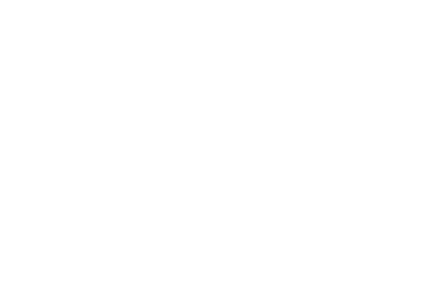

In [68]:
sigV_madx_p = beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1)
sigV_madx_p = sigV_madx_p.drop(sigV_madx_p.keys()[~sigV_madx_p.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
sigV_madx_m = -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1)
sigV_madx_m = sigV_madx_m.drop(sigV_madx_m.keys()[~sigV_madx_m.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
s = twiss_f61['s']
s = s.drop(s.keys()[~s.keys().isin(["t08.bpm073","t08.bpm080","t08.bpm092","t08.xwcm103"])])
fig, ax = plt.subplots()
ax.plot(s, sigV_madx_p)

In [69]:
sigV_madx_p.keys()[~sigV_madx_p.keys().isin(['t08.iron'])]

Index(['t08.bpm073', 't08.bpm080', 't08.bpm092', 't08.xwcm103'], dtype='object')

In [70]:
y = beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1)
y.tail(20)

drift_48[0]     0.005872
t08.xsec094     0.005933
drift_49[0]     0.006880
t08.btv096      0.006880
drift_50[0]     0.007068
t08.tmcrt097    0.007068
drift_51[0]     0.008268
t08.xwcm103     0.008301
drift_52[0]     0.008374
t08.marb        0.008374
drift_53[0]     0.008619
t08.iron        0.008619
drift_54[0]     0.009027
t08.catc        0.009027
t08.tde115      0.011064
drift_55[0]     0.011471
t08.conc        0.011471
t08.tde119      0.012081
t08.end         0.012081
#e              0.012081
dtype: float64

In [71]:
y = y["t08.xwcm103"] + 69

# Max and min of MWPC Hcenter

In [72]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [73]:
mwpc_hcenter = []
mwpc_vcenter = []
qd07_meas_pulse = []
for i in range(len(loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'])):
    mwpc_hcenter.append(loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][i]["HCenter"])
    mwpc_vcenter.append(loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][i]["VCenter"])
    qd07_meas_pulse.append(loaded_pickle[1]['T8.QDN07/MEAS.PULSE#VALUE'][i])

<IPython.core.display.Javascript object>


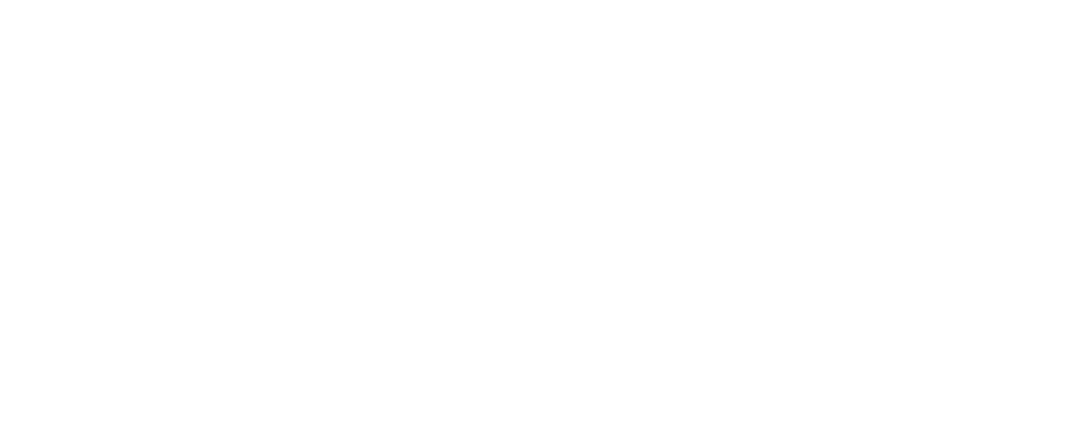

In [74]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax2 = ax[1].twinx()

ax[0].plot(qd07_meas_pulse[1:], mwpc_hcenter[1:], c="b", label="MWPC $\mu_{H}$")
ax[0].plot(qd07_meas_pulse[1:], mwpc_vcenter[1:], c="r", label="MWPC $\mu_{V}$")

ax[1].plot(qd07_meas_pulse[1:], mwpc_hcenter[1:], c="b", label="MWPC $\mu_{H}$")
ax2.plot(qd07_meas_pulse[1:], mwpc_vcenter[1:], c="r", label="MWPC $\mu_{V}$")

fig.suptitle("Movement of the centroid on the MWPC during a quadrupole scan")
ax[0].legend()
ax[0].set_ylabel("Centroid position [mm]")
ax[0].set_xlabel("Current QDN07 [A]")
ax[1].set_xlabel("Current QDN07 [A]")

plt.savefig("fig/centroid_movement_mpwc.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

# Let's make an ealign error

In [91]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")



mwpc_vcenter_madx = []
k_qdn07_list = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    
    madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
    madx.select(flag='error', pattern='T08.MQNFK061')

    y_error = 0.011465606879808077

    madx.input("EALIGN, DY="+str(y_error)+";")

    # Print the EFCOMP we put in for debugging
    madx.input("Select, flag=error, clear = true;")
    madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
    madx.input("EPRINT;")
    
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])
    k_qdn07_list.append(df.iloc[i].k_qdn07)

<IPython.core.display.Javascript object>


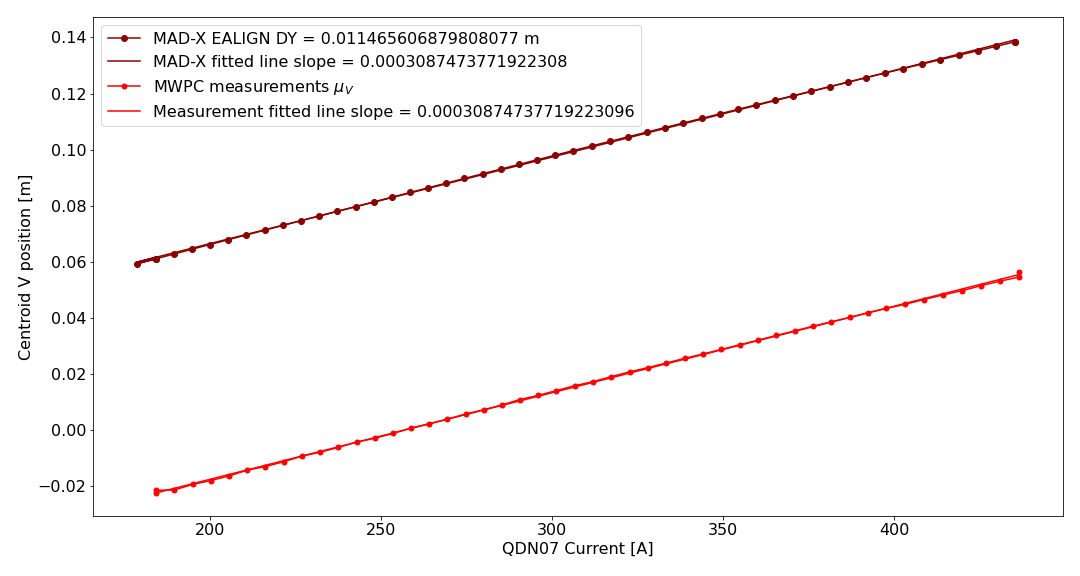

In [92]:
fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))


x = current(np.abs(k_qdn07_list), "Q200L", Brho)
y = mwpc_vcenter_madx
ax.plot(x, y, label=f"MAD-X EALIGN DY = {y_error} m", marker="o", c="darkred")

res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, c='darkred', label=f'MAD-X fitted line slope = {res.slope}')

slope_madx = res.slope

x = np.array(qd07_meas_pulse[1:])
y = np.array(mwpc_vcenter[1:])/1000
ax.plot(x, y, c="r", marker="o", ms=5, label="MWPC measurements $\mu_{V}$")
res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, 'r', label=f'Measurement fitted line slope = {res.slope}')

slope_meas = res.slope

ax.legend()
ax.set_ylabel("Centroid V position [m]")
ax.set_xlabel("QDN07 Current [A]")

plt.savefig("fig/ealign_madx_vs_measurement.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

<IPython.core.display.Javascript object>


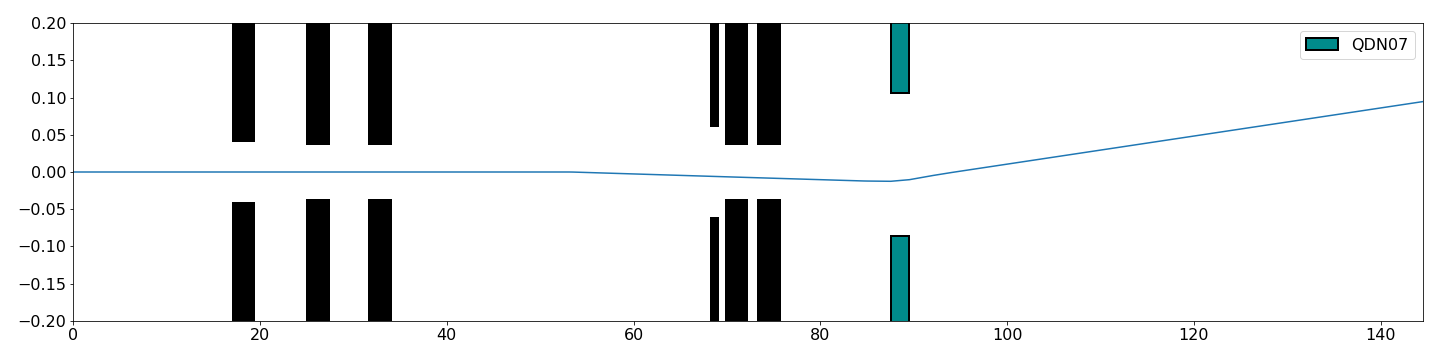

In [90]:
fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)
ax.plot(twiss_f61.s, twiss_f61.y)
draw_aperture(ax, twiss_f61, 'aper_2')
ax.set_xlim(0, 144.5)

dy_align = 0.01

rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + dy_align), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor='darkcyan')
ax.add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], 0.0965 + dy_align), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor='darkcyan', label="QDN07")
ax.add_patch(rect)

ax.set_ylim(-0.2, 0.2)
ax.legend()

<IPython.core.display.Javascript object>


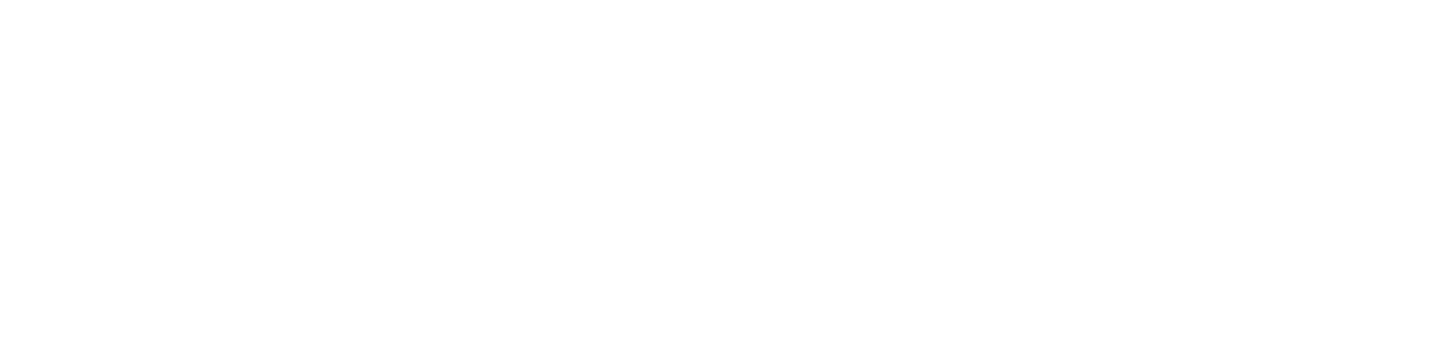

In [78]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

%matplotlib notebook
fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")



mwpc_vcenter_madx = []

y_error_list = np.linspace(-0.05, 0.05, 50)
def animate(i):
    
    instrument_focal_point = "t08.xwcm103"

    y_error = y_error_list[i]
    ax.clear()

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[1].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[1].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[1].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[1].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[1].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[1].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[1].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[1].k_qfn08)+";")
    
    madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
    madx.select(flag='error', pattern='T08.MQNFK061')

    madx.input("EALIGN, DY="+str(y_error)+";")

    # Print the EFCOMP we put in for debugging
    madx.input("Select, flag=error, clear = true;")
    madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
    madx.input("EPRINT;")
    
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])
    
    
    ax.plot(twiss_f61.s, twiss_f61.y)
    draw_aperture(ax, twiss_f61, 'aper_2')
    ax.set_xlim(0, 144.5)


    rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[1].k_qdn07)*10,0,1))
    ax.add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], 0.0965 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[1].k_qdn07)*10,0,1), label="QDN07")
    ax.add_patch(rect)
    
    ax.set_ylim(-0.2, 0.2)
    ax.legend(loc="upper right")
    
    ax.set_title(f"Beam movement if QDN07 quadrupole misaligned by {y_error} [m] at constant current, k = {round(df.iloc[i].k_qdn07, 3)} [$m^{-2}$]")
    
ani = FuncAnimation(fig, animate, interval=1, blit=True, repeat=False, frames=len(y_error_list))
ani.save("gif/ealign_position_change.gif", dpi=300, writer=PillowWriter(fps=10))

# Beam movement if we change k in the quadrupole with a displacement

<IPython.core.display.Javascript object>


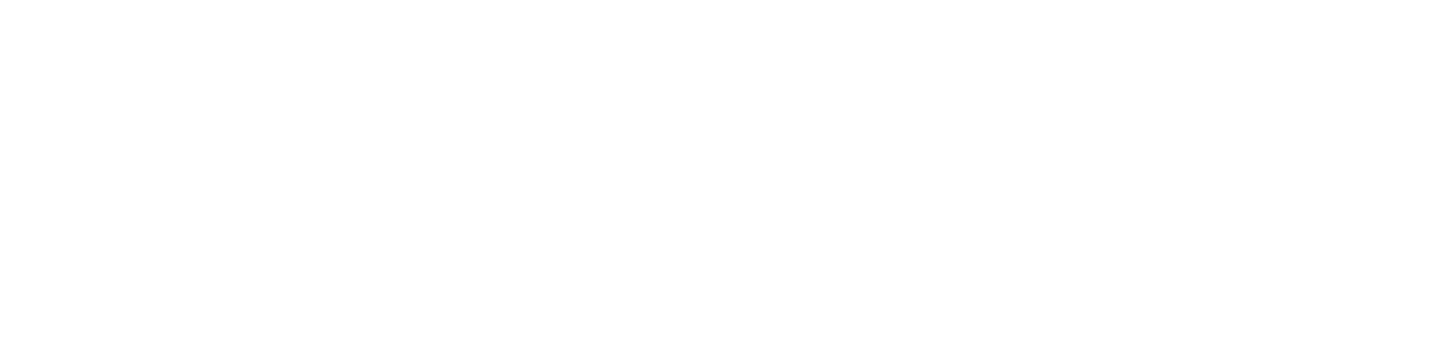

In [79]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

%matplotlib notebook
fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")



mwpc_vcenter_madx = []


def animate(i):
    
    instrument_focal_point = "t08.xwcm103"

    ax.clear()

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    
    y_error = 0.01
    
    madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
    madx.select(flag='error', pattern='T08.MQNFK061')

    
    madx.input("EALIGN, DY="+str(y_error)+";")

    # Print the EFCOMP we put in for debugging
    madx.input("Select, flag=error, clear = true;")
    madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
    madx.input("EPRINT;")
    
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])
    
    ax.plot(twiss_f61.s, twiss_f61.y)
    draw_aperture(ax, twiss_f61, 'aper_2')
    ax.set_xlim(0, 144.5)

    rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[i].k_qdn07)*10,0,1))
    ax.add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], 0.0965 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[i].k_qdn07)*10,0,1), label="QDN07")
    ax.add_patch(rect)
    
    ax.set_ylim(-0.2, 0.2)
    ax.legend(loc = "upper right")
    
    ax.set_title(f"Beam movement if QDN07 quadrupole misaligned by {y_error} [m] at varying current, k = {round(df.iloc[i].k_qdn07, 3)} [$m^{-2}$]")
    
ani = FuncAnimation(fig, animate, interval=1, blit=True, repeat=False, frames=len(df))
ani.save("gif/ealign_current_change.gif", dpi=300, writer=PillowWriter(fps=10))

<IPython.core.display.Javascript object>


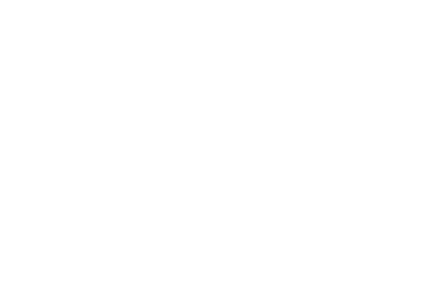

In [80]:
fig, ax = plt.subplots()
rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(0.9, 0, 1))
ax.add_patch(rect)
ax.plot(twiss_f61.s, twiss_f61.y)
# ax.set_xlim(0,140)
# ax.set_xlim(-1,1)

# No error

<IPython.core.display.Javascript object>


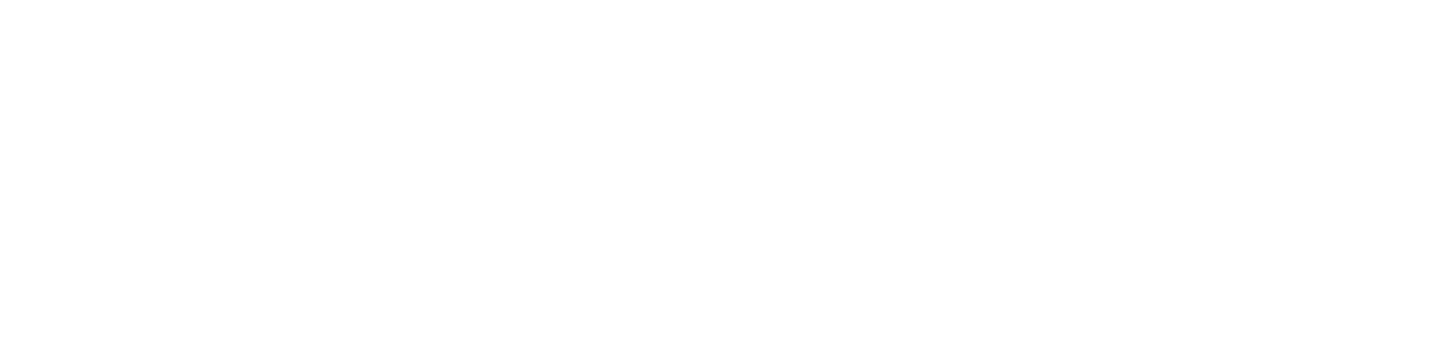

In [81]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

%matplotlib notebook
fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")



mwpc_vcenter_madx = []


def animate(i):
    
    instrument_focal_point = "t08.xwcm103"

    ax.clear()

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    
    y_error = 0.00
    
    madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
    madx.select(flag='error', pattern='T08.MQNFK061')

    
    madx.input("EALIGN, DY="+str(y_error)+";")

    # Print the EFCOMP we put in for debugging
    madx.input("Select, flag=error, clear = true;")
    madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
    madx.input("EPRINT;")
    
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])
    
    ax.plot(twiss_f61.s, twiss_f61.y)
    draw_aperture(ax, twiss_f61, 'aper_2')
    ax.set_xlim(0, 144.5)

    rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[i].k_qdn07)*10,0,1))
    ax.add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], 0.0965 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[i].k_qdn07)*10,0,1), label="QDN07")
    ax.add_patch(rect)
    
    ax.set_ylim(-0.2, 0.2)
    ax.legend(loc = "upper right")
    
    ax.set_title(f"Beam movement if QDN07 quadrupole misaligned by {y_error} [m] at varying current, k = {round(df.iloc[i].k_qdn07, 3)} [$m^{-2}$]")
    
ani = FuncAnimation(fig, animate, interval=1, blit=True, repeat=False, frames=len(df))
ani.save("gif/ealign_current_change_no_error.gif", dpi=300, writer=PillowWriter(fps=10))

# With the vertical correctors

<IPython.core.display.Javascript object>


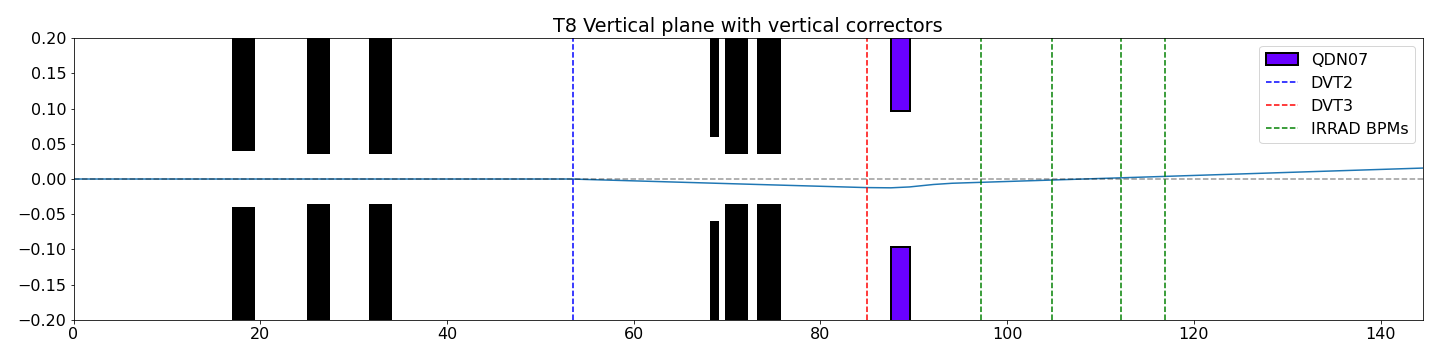

In [82]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

%matplotlib notebook
fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

# Initial vertical kicker strengths
madx.input("kDVT2 = -0.000388;")
madx.input("kDVT3 = 0.000250;")

mwpc_vcenter_madx = []
   
instrument_focal_point = "t08.xwcm103"

ax.clear()

# Computed quad strength with values from 2021-11-12
madx.input("kQFN1 = "+str(df.iloc[1].k_qfn01)+";")
madx.input("kQDN2 = "+str(df.iloc[1].k_qdn02)+";")
madx.input("kQFN3 = "+str(df.iloc[1].k_qfn03)+";")
madx.input("kQDN4 = "+str(df.iloc[1].k_qdn04)+";")
madx.input("kQFN5 = "+str(df.iloc[1].k_qfn05)+";")
madx.input("kQDN6 = "+str(df.iloc[1].k_qdn06)+";")
madx.input("kQDN7 = "+str(-0.061403)+";")
madx.input("kQFN8 = "+str(0.069031)+";")

y_error = 0.00

madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
madx.select(flag='error', pattern='T08.MQNFK061')


madx.input("EALIGN, DY="+str(y_error)+";")

# Print the EFCOMP we put in for debugging
madx.input("Select, flag=error, clear = true;")
madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
madx.input("EPRINT;")

twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])

ax.plot(twiss_f61.s, twiss_f61.y)
draw_aperture(ax, twiss_f61, 'aper_2')
ax.set_xlim(0, 144.5)

rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[1].k_qdn07)*10,0,1))
ax.add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], 0.0965 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[1].k_qdn07)*10,0,1), label="QDN07")
ax.add_patch(rect)

ax.set_ylim(-0.2, 0.2)

ax.axvline(twiss_f61.s["t08.mcxcf026"], linestyle = "--", color = "b", label="DVT2")
ax.axvline(twiss_f61.s["t08.mcxcf057"], linestyle = "--", color = "r", label="DVT3")

ax.axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g", label="IRRAD BPMs")
ax.axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
ax.axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
ax.axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

ax.axhline(0.0, ls="--", c="k", alpha=0.4)

ax.legend(loc = "upper right")
ax.set_title("T8 Vertical plane with vertical correctors")
plt.savefig("fig/vertical_correctors.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

# zoom

<IPython.core.display.Javascript object>


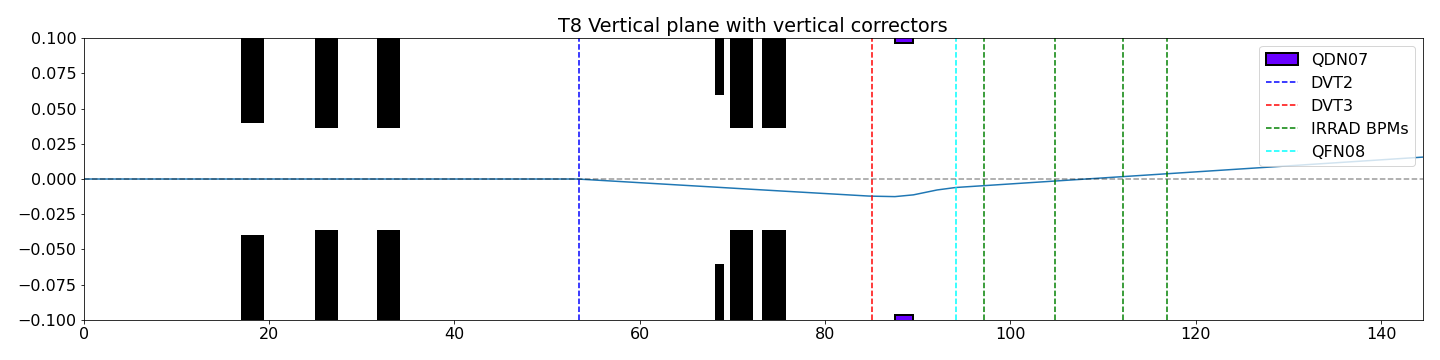

In [84]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

# Initial vertical kicker strengths
madx.input("kDVT2 = -0.000388;")
madx.input("kDVT3 = 0.000250;")

mwpc_vcenter_madx = []
   
instrument_focal_point = "t08.xwcm103"

ax.clear()

# Computed quad strength with values from 2021-11-12
madx.input("kQFN1 = "+str(df.iloc[1].k_qfn01)+";")
madx.input("kQDN2 = "+str(df.iloc[1].k_qdn02)+";")
madx.input("kQFN3 = "+str(df.iloc[1].k_qfn03)+";")
madx.input("kQDN4 = "+str(df.iloc[1].k_qdn04)+";")
madx.input("kQFN5 = "+str(df.iloc[1].k_qfn05)+";")
madx.input("kQDN6 = "+str(df.iloc[1].k_qdn06)+";")
madx.input("kQDN7 = "+str(-0.061403)+";")
madx.input("kQFN8 = "+str(0.069031)+";")

y_error = 0.00

madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
madx.select(flag='error', pattern='T08.MQNFK061')


madx.input("EALIGN, DY="+str(y_error)+";")

# Print the EFCOMP we put in for debugging
madx.input("Select, flag=error, clear = true;")
madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
madx.input("EPRINT;")

twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])

ax.plot(twiss_f61.s, twiss_f61.y)
draw_aperture(ax, twiss_f61, 'aper_2')
ax.set_xlim(0, 144.5)

rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], -1 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[1].k_qdn07)*10,0,1))
ax.add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.mqnfk061"], 0.0965 + y_error), -2.0 , 1-0.0965, linewidth=2, edgecolor='k', facecolor=(abs(df.iloc[1].k_qdn07)*10,0,1), label="QDN07")
ax.add_patch(rect)

ax.set_ylim(-0.1, 0.1)

ax.axvline(twiss_f61.s["t08.mcxcf026"], linestyle = "--", color = "b", label="DVT2")
ax.axvline(twiss_f61.s["t08.mcxcf057"], linestyle = "--", color = "r", label="DVT3")

ax.axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g", label="IRRAD BPMs")
ax.axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
ax.axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
ax.axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

ax.axvline(twiss_f61.s['t08.mqnfk066'], linestyle = "--", color = "cyan", label="QFN08")

ax.axhline(0.0, ls="--", c="k", alpha=0.4)

ax.legend(loc = "upper right")
ax.set_title("T8 Vertical plane with vertical correctors")
plt.savefig("fig/vertical_correctors_zoom.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

<IPython.core.display.Javascript object>


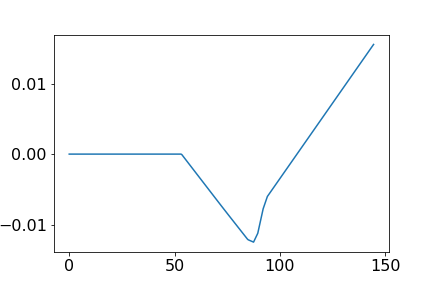

In [85]:
fig, ax = plt.subplots()
ax.plot(twiss_f61.s, twiss_f61.y)

In [86]:
print(str(round(twiss_f61.loc["t08.bpm073"].y*1000,2))+" mm")
print(str(round(twiss_f61.loc["t08.bpm080"].y*1000,2))+" mm")
print(str(round(twiss_f61.loc["t08.bpm085"].y*1000,2))+" mm")
print(str(round(twiss_f61.loc["t08.bpm092"].y*1000,2))+" mm")

-4.7 mm
-1.44 mm
1.72 mm
3.76 mm


In [87]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

# Initial vertical kicker strengths
madx.input("kDVT2 = -0.000388;")
madx.input("kDVT3 = 0.000250;")

mwpc_vcenter_madx = []
k_qdn07_list = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    
    madx.input("Select, flag=error, clear = true;") # Very IMPORTANT, This is because otherwise you will select element previously selected with your pattern
    madx.select(flag='error', pattern='T08.MQNFK061')

    y_error = 0.0

    madx.input("EALIGN, DY="+str(y_error)+";")

    # Print the EFCOMP we put in for debugging
    madx.input("Select, flag=error, clear = true;")
    madx.input("SELECT, FLAG=ERROR, PATTERN='T08.MQNFK061';")
    madx.input("EPRINT;")
    
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    mwpc_vcenter_madx.append(twiss_f61.y["t08.xwcm103"])
    k_qdn07_list.append(df.iloc[i].k_qdn07)

<IPython.core.display.Javascript object>


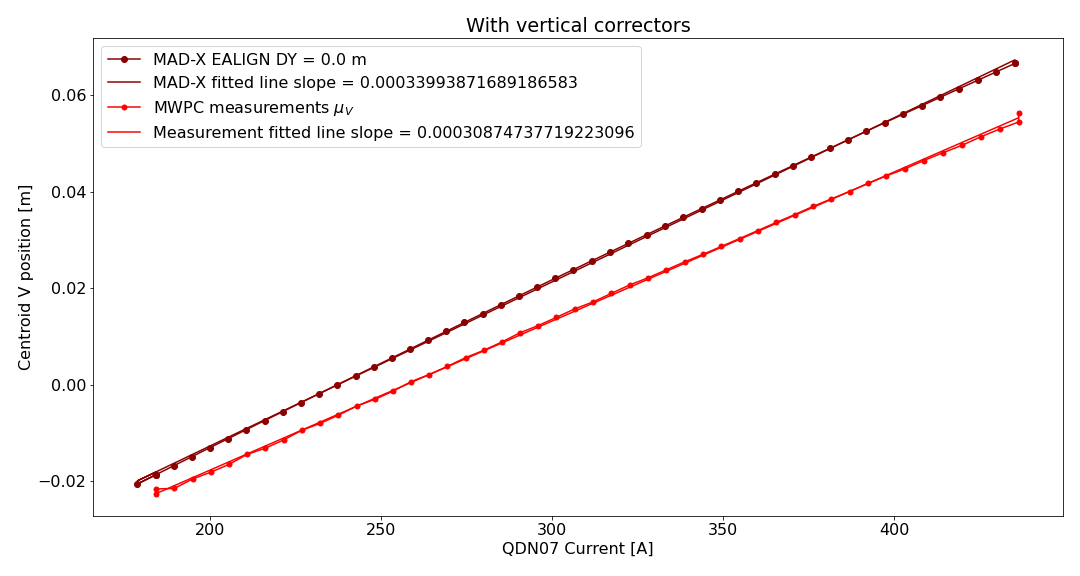

In [88]:
fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))


x = current(np.abs(k_qdn07_list), "Q200L", Brho)
y = mwpc_vcenter_madx
ax.plot(x, y, label=f"MAD-X EALIGN DY = {y_error} m", marker="o", c="darkred")

res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, c='darkred', label=f'MAD-X fitted line slope = {res.slope}')

slope_madx = res.slope

x = np.array(qd07_meas_pulse[1:])
y = np.array(mwpc_vcenter[1:])/1000
ax.plot(x, y, c="r", marker="o", ms=5, label="MWPC measurements $\mu_{V}$")
res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, 'r', label=f'Measurement fitted line slope = {res.slope}')

slope_meas = res.slope

ax.legend()
ax.set_ylabel("Centroid V position [m]")
ax.set_xlabel("QDN07 Current [A]")
ax.set_title("With vertical correctors")

plt.savefig("fig/ealign_madx_vs_measurement_2.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

In [95]:
(0.02+0.06) * 1000

80.0